# First load in some packages and plotting defaults

In [1]:
import matplotlib
import matplotlib.pyplot as plt

#import colormaps as cmaps


matplotlib.rc("xtick", labelsize=27)
matplotlib.rc("ytick", labelsize=27)
matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rc("text", usetex=True)

In [2]:
from astropy.time import Time
from astropy.coordinates import get_body, solar_system_ephemeris
import numpy as np

# Use a precise planetary ephemeris
solar_system_ephemeris.set('de432s')

# Define the J2000 epoch
j2000 = Time('2000-01-01 12:00:00', scale='tdb')

# Get positions of Earth and Moon in ICRS (inertial space)
earth = get_body('earth', j2000)
moon = get_body('moon', j2000)

# Vector from Moon to Earth (as seen from the Moon, in ICRS frame)
vector = earth.cartesian - moon.cartesian
x, y, z = vector.get_xyz().value

# Compute θ = angle from ICRS X-axis (vernal equinox) in the XY plane
theta_rad = np.arctan2(y, x)
theta_deg = np.degrees(theta_rad)

# Wrap angle to [-180°, +180°] for Mollweide compatibility
theta_wrapped = ((theta_deg + 180) % 360) - 180

print(f"Earth appears at lunar longitude θ = {theta_wrapped:.2f}° in your coordinate system")


Earth appears at lunar longitude θ = 42.45° in your coordinate system


# Now let's try a Mollweide projection of the whole Moon

## let's plot the impact rate with a 10^-6 g minimum mass

#### this represents the impact rate for all micrometeoroids, so with no consideration for reasonable shielding
#### i.e., this answers the question what is NASA does no shielding (which obviously it will not do.....)

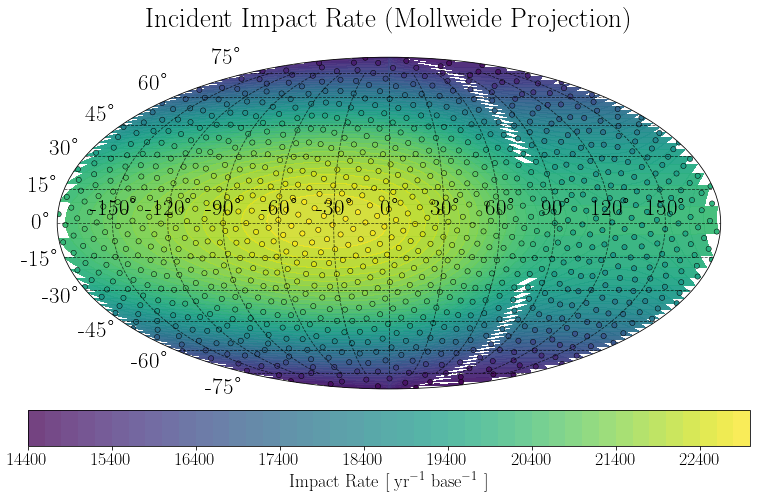

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
from matplotlib.ticker import FixedLocator, FuncFormatter



# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.arange(0,360, 1.0),
                                   np.linspace(0, 180, 90))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)


# Set color limits
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# Convert to Mollweide coordinates
theta_moll = np.radians(((theta_list + 180) % 360) - 180)
phi_moll = np.radians((phi_list - 90) * -1.0)
theta_grid_moll = np.radians(((theta_grid + 180) % 360) - 180)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)


#theta_moll = np.radians(theta_list - 180)
#theta_grid_moll = np.radians(theta_grid - 180)

# Plot
fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(111, projection="mollweide")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=50,
                 cmap="viridis", alpha=0.75)


# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                s=27, edgecolors="black", linewidth=0.5)

# Create colorbar normally
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=18)

# ---- Now modify colorbar properly ----
'''
# Define desired tick values
num_ticks = 5  # number of ticks you want
tick_vals = np.linspace(vmin, vmax, num_ticks)

# Custom formatter
def smart_format(x, pos):
    if abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

# Apply locator and formatter at colorbar level
cbar.set_ticks(tick_vals)  # <- This sets the actual ticks
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])  # <- This sets labels
'''
cbar.ax.tick_params(labelsize=18)

#change angle fontsizes
ax.tick_params(axis='both', which='major', labelsize=23)


# Grid and layout and title
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Incident Impact Rate (Mollweide Projection)", fontsize = 27, pad=30)


plt.tight_layout()

#plt.savefig('./figures/impact_rate_mollweide.pdf')

plt.show()


/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_62649/2944218943.py:63: UserWarning: The following kwargs were not used by contour: 'rasterized'
  cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=30,


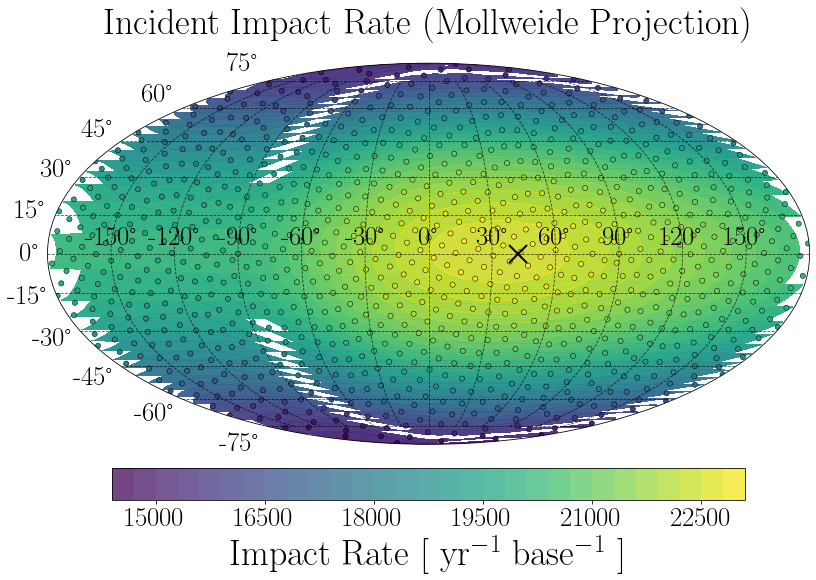

In [4]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)     # now in [-180, +180)
phi_wrapped = phi_list                      # unchanged
impact_rate_wrapped = impact_rate           # unchanged

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))

theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()


interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Color Limits ----------
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(11*1.0909, 8))
ax = fig.add_subplot(111, projection="mollweide")

#plot Earth location
ax.plot(np.radians(42.45), 0,
        'x', ms=18,
        mfc='black', mec='black', mew=2,
        zorder=1000, label="Earth")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=30,
                 cmap="viridis", alpha=0.75, rasterized=True)

# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                s=27, edgecolors="black", linewidth=0.5, rasterized=True)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)
cbar.locator = MaxNLocator(nbins=8, integer=True, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=27)

# Tick fontsizes
ax.tick_params(axis='both', which='major', labelsize=27)

# Grid and layout and title
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Incident Impact Rate (Mollweide Projection)", fontsize=36, pad=30)

plt.tight_layout()
plt.savefig('./figures/impact_rate_mollweide.pdf', bbox_inches='tight')
plt.show()


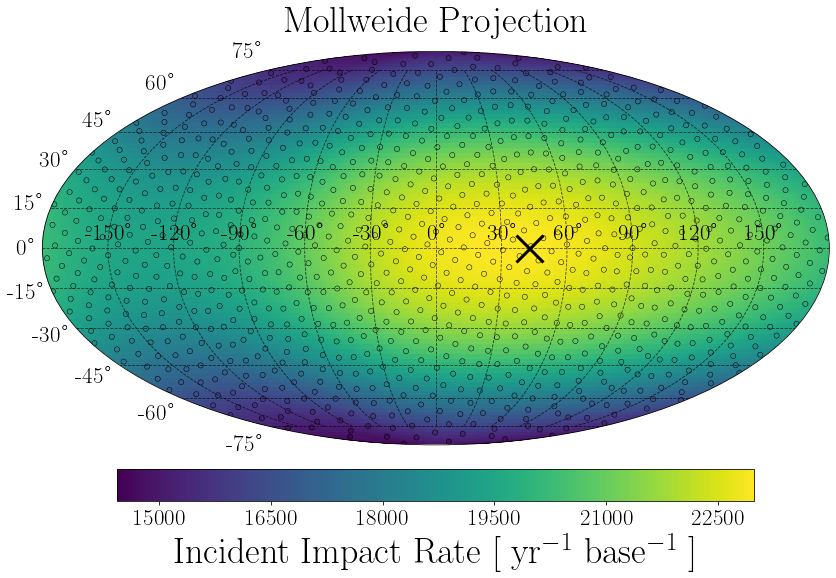

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

def add_cyclic(lon2d_deg, data2d):
    """Append the first column shifted by +360° to make the grid cyclic in longitude."""
    lon_cyc = np.hstack([lon2d_deg, lon2d_deg[:, :1] + 360.0])
    data_cyc = np.hstack([data2d,   data2d[:,   :1]])
    return lon_cyc, data_cyc

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Consistent lon/lat convention ----------
lon_data = wrap_to_180(-theta_list)     # [-180, 180)
lat_data = 90.0 - phi_list              # [-90, 90]

# ---------- (Optional) augment for periodicity ----------
lon_aug = np.concatenate([lon_data, lon_data - 360.0, lon_data + 360.0])
lat_aug = np.concatenate([lat_data, lat_data,          lat_data])
vals_aug = np.concatenate([impact_rate, impact_rate,   impact_rate])

# ---------- RBF interpolant ----------
rbf = Rbf(lon_aug, lat_aug, vals_aug, function="multiquadric", smooth=1.0)

# ---------- Evaluation Grid ----------
nlon, nlat = 180, 90
lon_eval = np.linspace(-180.0, 180.0, nlon, endpoint=False)  # [-180, 180)
lat_eval = np.linspace(-90.0,  90.0,  nlat)                  # [-90, 90]
lon_grid, lat_grid = np.meshgrid(lon_eval, lat_eval)

grid_vals = rbf(lon_grid, lat_grid)

# ---------- Make the grid cyclic ----------
lon_plot_deg, grid_cyc = add_cyclic(lon_grid, grid_vals)
lat_plot_deg = np.hstack([lat_grid, lat_grid[:, :1]])   # <-- FIX: match shape (90,181)

# ---------- To radians ----------
lon_plot_rad = np.radians(lon_plot_deg)
lat_plot_rad = np.radians(lat_plot_deg)                 # <-- FIX: use the cyclic lat

lon_scatter_rad = np.radians(lon_data)
lat_scatter_rad = np.radians(lat_data)

# ---------- Plot ----------
fig = plt.figure(figsize=(11*1.0909, 8))
ax = fig.add_subplot(111, projection="mollweide")

pm = ax.pcolormesh(lon_plot_rad, lat_plot_rad, grid_cyc,
                   cmap="viridis", shading="auto")

ax.scatter(lon_scatter_rad, lat_scatter_rad, c=impact_rate, cmap="viridis",
           s=27, edgecolors="black", linewidth=0.5)

ax.plot(np.radians(42.45), 0.0, 'x', ms=27,
        mfc='black', mec='black', mew=3, zorder=1000, label="Earth")

cbar = plt.colorbar(pm, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Incident Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)
cbar.locator = MaxNLocator(nbins=8, integer=False, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=23)

ax.tick_params(axis='both', which='major', labelsize=23)
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Mollweide Projection", fontsize=36, pad=20)

plt.tight_layout()
plt.savefig('./figures/impact_rate_mollweide.pdf', bbox_inches='tight')
plt.show()


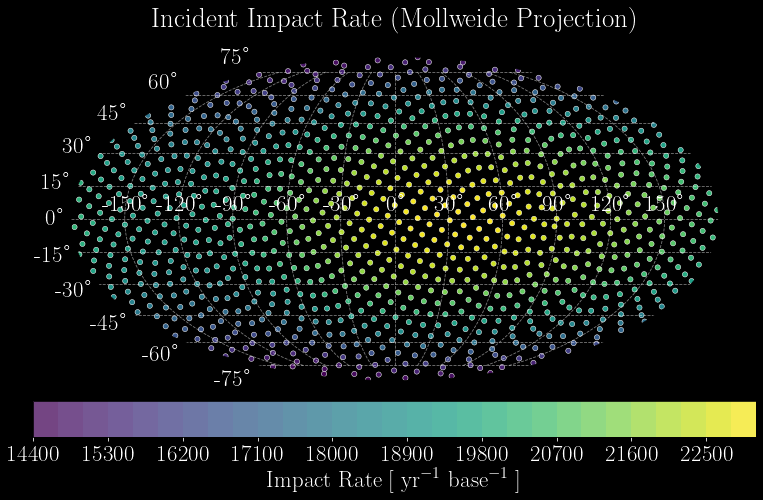

In [6]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)
phi_wrapped = phi_list
impact_rate_wrapped = impact_rate

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))
theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()
interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(13, 7), facecolor='black')
ax = fig.add_subplot(111, projection="mollweide", facecolor='black')


# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                s=27, edgecolors="white", linewidth=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

# Tick font colors
ax.tick_params(axis='both', which='major', labelsize=23, colors='white')

# Grid and layout and title
plt.grid(True, linestyle="--", color="white", alpha=0.5)
plt.title("Incident Impact Rate (Mollweide Projection)",
          fontsize=27, pad=30, color='white')

plt.tight_layout()
plt.savefig('./figures/impact_rate_mollweide_no_interpolate_dark.pdf', facecolor='black')
plt.show()


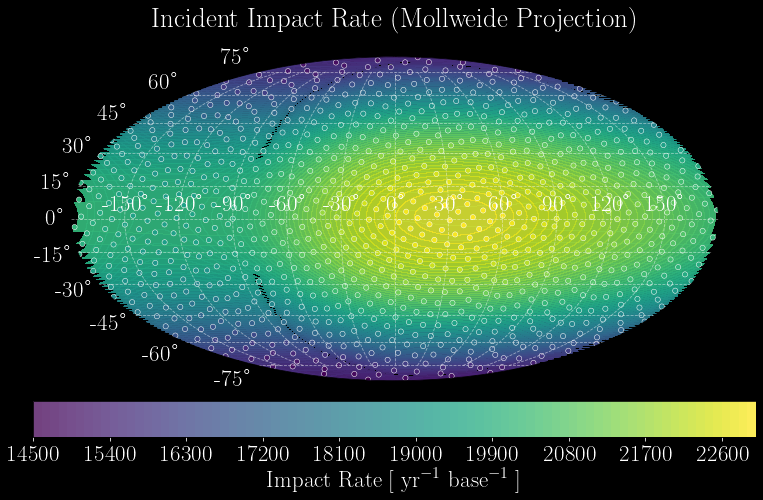

In [7]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)
phi_wrapped = phi_list
impact_rate_wrapped = impact_rate

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))
theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()
interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(13, 7), facecolor='black')
ax = fig.add_subplot(111, projection="mollweide", facecolor='black')


# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                 cmap="viridis", alpha=0.75)

# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                s=27, edgecolors="white", linewidth=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

# Tick font colors
ax.tick_params(axis='both', which='major', labelsize=23, colors='white')

# Grid and layout and title
plt.grid(True, linestyle="--", color="white", alpha=0.5)
plt.title("Incident Impact Rate (Mollweide Projection)",
          fontsize=27, pad=30, color='white')

plt.tight_layout()
plt.savefig('./figures/impact_rate_mollweide_noEarth_dark.pdf', facecolor='black')
plt.show()


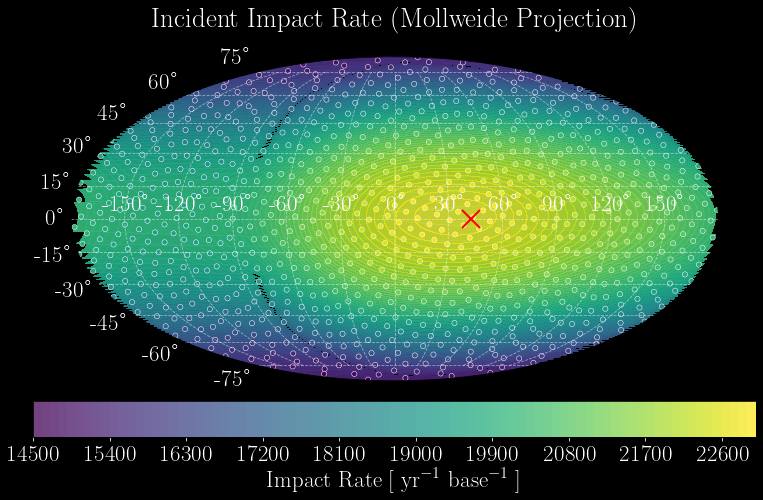

In [8]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)
phi_wrapped = phi_list
impact_rate_wrapped = impact_rate

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))
theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()
interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(13, 7), facecolor='black')
ax = fig.add_subplot(111, projection="mollweide", facecolor='black')

# Plot Earth location
ax.plot(np.radians(42.45), 0,
        'x', ms=18,
        mfc='red', mec='red', mew=2,
        zorder=1000, label="Earth")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                 cmap="viridis", alpha=0.75)

# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                s=27, edgecolors="white", linewidth=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

# Tick font colors
ax.tick_params(axis='both', which='major', labelsize=23, colors='white')

# Grid and layout and title
plt.grid(True, linestyle="--", color="white", alpha=0.5)
plt.title("Incident Impact Rate (Mollweide Projection)",
          fontsize=27, pad=30, color='white')

plt.tight_layout()
plt.savefig('./figures/impact_rate_mollweide_dark.pdf', facecolor='black')
plt.show()


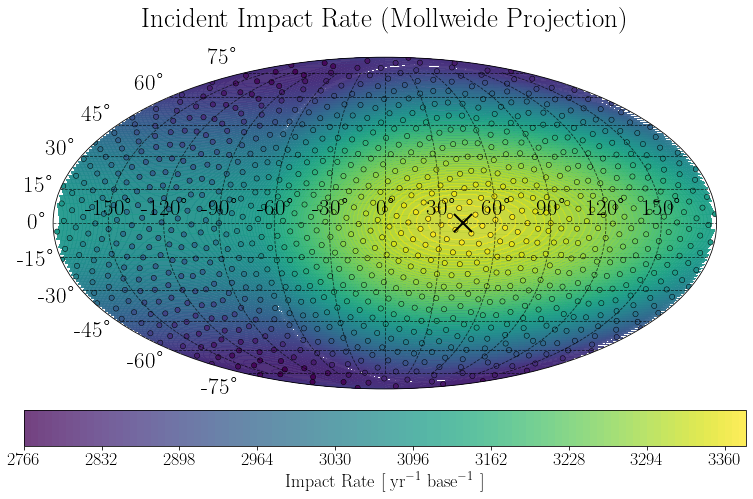

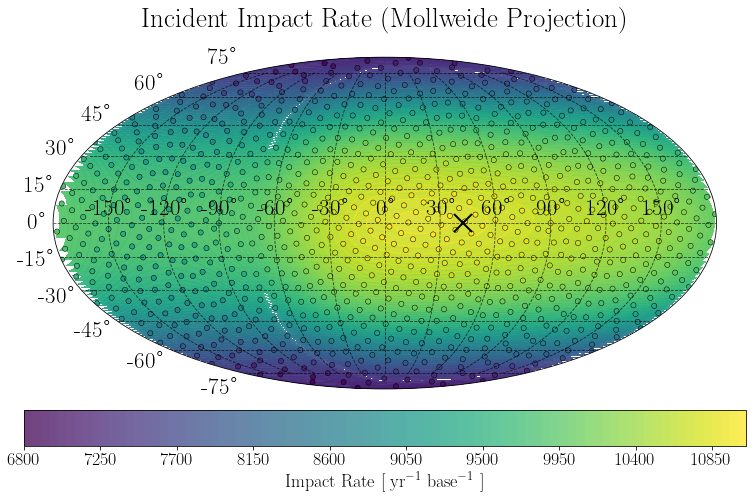

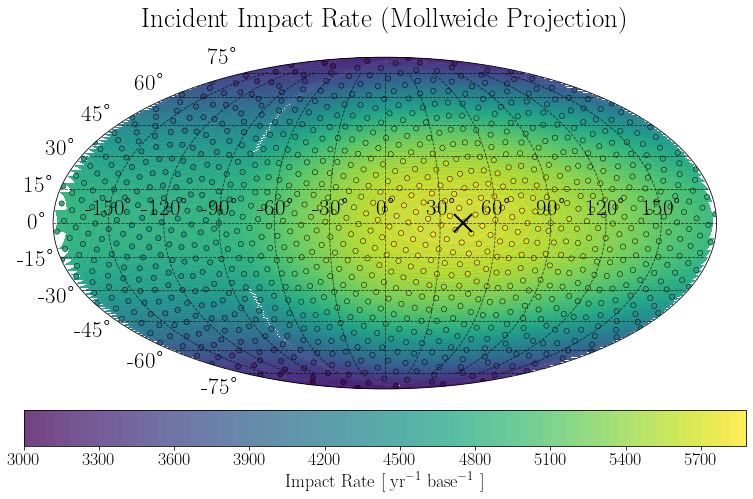

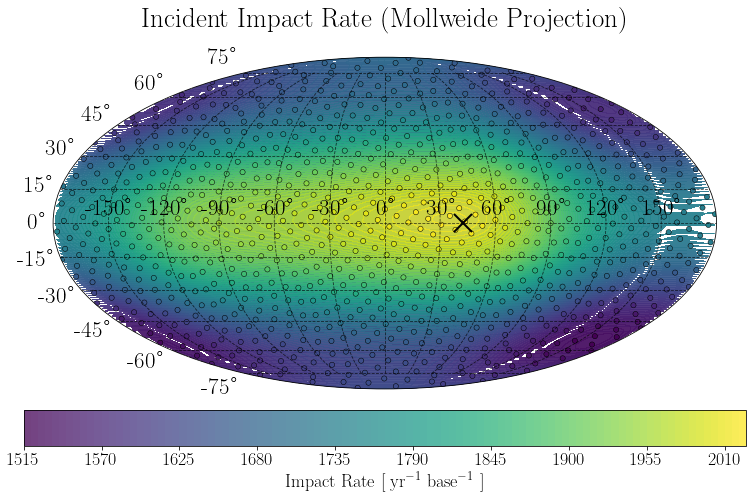

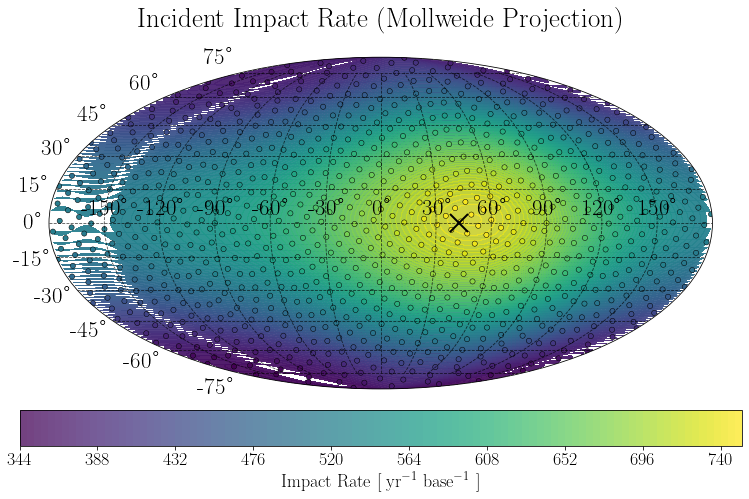

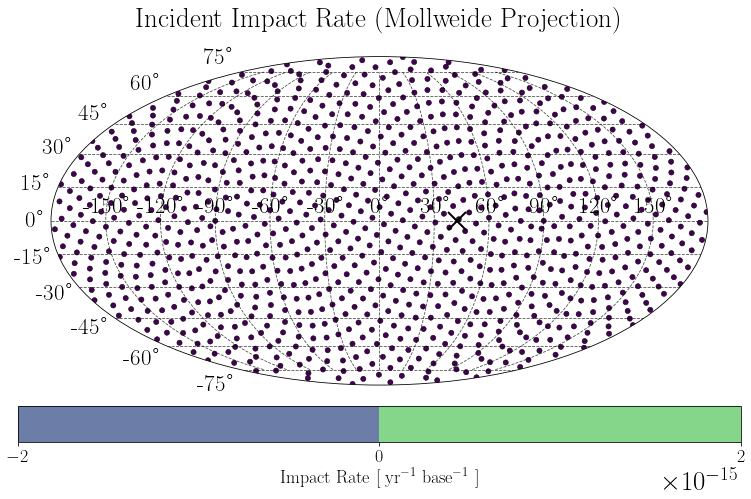

In [9]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
vel_split_files = [
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_0_15.csv",
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_15_30.csv",
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_30_45.csv",
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_45_60.csv",
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_60_75.csv",
    "./impact_rate_results/flux_files/flux_rates_1000_m6_vrange_75_90.csv"]

for file in vel_split_files:
    df = pd.read_csv(file)
    theta_list = np.array(df["theta"])     # 0–360°
    phi_list = np.array(df["phi"])         # 0–180°, 0 = north
    impact_rate = np.array(df["flux"])     # impacts/year

    # ---------- Apply Wrapping to Longitudes ----------
    theta_wrapped = wrap_to_180(-theta_list)     # now in [-180, +180)
    phi_wrapped = phi_list                      # unchanged
    impact_rate_wrapped = impact_rate           # unchanged

    # ---------- Interpolation Function ----------
    def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
        rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
        return rbf(theta_eval, phi_eval)

    # ---------- Interpolation Grid ----------
    theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                       np.linspace(0, 180, 90))

    theta_grid_wrapped = wrap_to_180(theta_grid)
    theta_flat = theta_grid_wrapped.flatten()
    phi_flat = phi_grid.flatten()


    interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                      phi_flat, theta_flat)
    impact_rate_grid = interp_flat.reshape(phi_grid.shape)

    # ---------- Color Limits ----------
    vmin = np.min(impact_rate)
    vmax = np.max(impact_rate)

    # ---------- Convert to Mollweide Coordinates ----------
    theta_moll = np.radians(theta_wrapped)
    phi_moll = np.radians((phi_wrapped - 90) * -1.0)
    theta_grid_moll = np.radians(theta_grid_wrapped)
    phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

    # ---------- Plot ----------
    fig = plt.figure(figsize=(13, 7))
    ax = fig.add_subplot(111, projection="mollweide")

    #plot Earth location
    ax.plot(np.radians(42.45), 0,
            'x', ms=18,
            mfc='black', mec='black', mew=2,
            zorder=1000, label="Earth")

    # Contour plot
    cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                     cmap="viridis", alpha=0.75)

    # Scatter plot
    sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="viridis",
                    s=27, edgecolors="black", linewidth=0.5)

    # Colorbar
    cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
    cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Tick fontsizes
    ax.tick_params(axis='both', which='major', labelsize=23)

    # Grid and layout and title
    plt.grid(True, linestyle="--", color="black", alpha=.7)
    plt.title("Incident Impact Rate (Mollweide Projection)", fontsize=27, pad=30)

    plt.tight_layout()
    #plt.savefig('./figures/impact_rate_mollweide_high_vel.pdf')
    plt.show()

## Now let's look at our 10^-1.16 g best guest for minimum mass with current Whipple shielding

#### that is the "shielded" impact rate

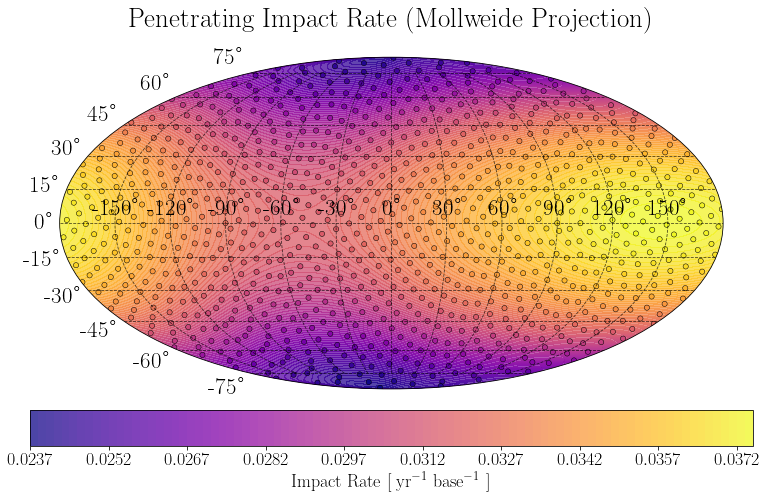

In [10]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
from matplotlib.ticker import FixedLocator, FuncFormatter



# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)


# Set color limits
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# Convert to Mollweide coordinates
theta_moll = np.radians(theta_list - 180)
phi_moll = np.radians((phi_list - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid - 180)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# Plot
fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(111, projection="mollweide")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                 cmap="plasma", alpha=0.75)


# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="plasma",
                s=27, edgecolors="black", linewidth=0.5)

# Create colorbar normally
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=18)

# ---- Now modify colorbar properly ----
'''
# Define desired tick values
num_ticks = 5  # number of ticks you want
tick_vals = np.linspace(vmin, vmax, num_ticks)

# Custom formatter
def smart_format(x, pos):
    if abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

# Apply locator and formatter at colorbar level
cbar.set_ticks(tick_vals)  # <- This sets the actual ticks
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])  # <- This sets labels
'''
cbar.ax.tick_params(labelsize=18)

#change angle fontsizes
ax.tick_params(axis='both', which='major', labelsize=23)


# Grid and layout and title
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Penetrating Impact Rate (Mollweide Projection)", fontsize = 27, pad=30)


plt.tight_layout()

#plt.savefig('./figures/shielded_impact_rate_mollweide.pdf')

plt.show()


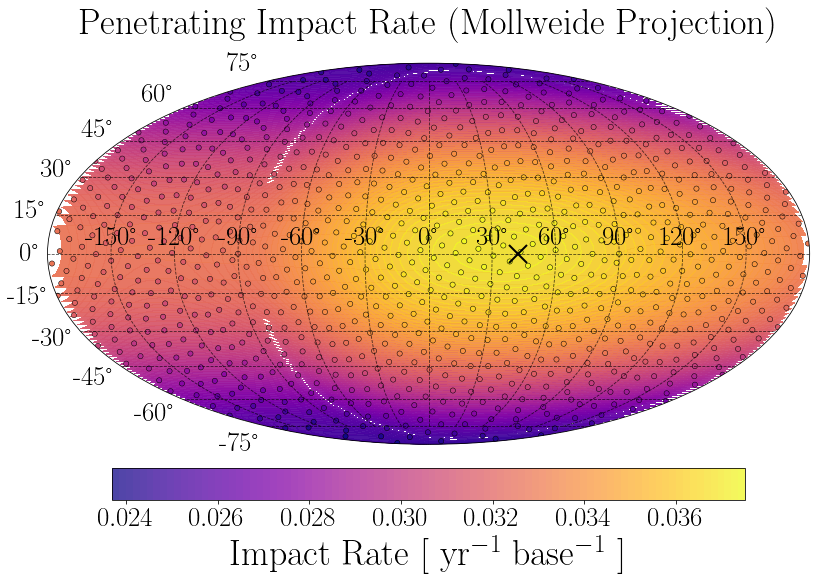

In [11]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)     # now in [-180, +180)
phi_wrapped = phi_list                      # unchanged
impact_rate_wrapped = impact_rate           # unchanged

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))

theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()


interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Color Limits ----------
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(11*1.0909, 8))
ax = fig.add_subplot(111, projection="mollweide")

#plot Earth location
ax.plot(np.radians(42.45), 0,
        'x', ms=18,
        mfc='black', mec='black', mew=2,
        zorder=1000, label="Earth")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                 cmap="plasma", alpha=0.75)

# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="plasma",
                s=27, edgecolors="black", linewidth=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)
cbar.locator = MaxNLocator(nbins=8, integer=True, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=27)

# Tick fontsizes
ax.tick_params(axis='both', which='major', labelsize=27)

# Grid and layout and title
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Penetrating Impact Rate (Mollweide Projection)", fontsize=36, pad=30)

plt.tight_layout()
plt.savefig('./figures/shielded_impact_rate_mollweide.pdf')
plt.show()

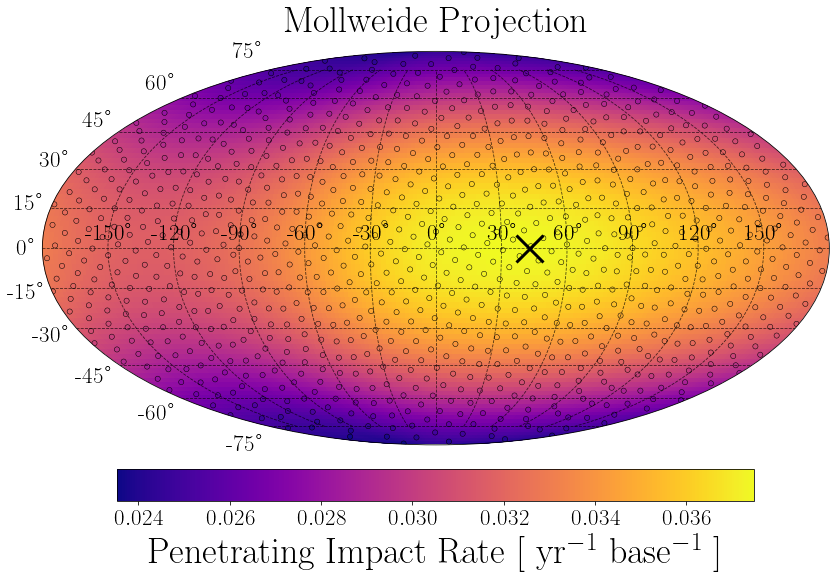

In [12]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

def add_cyclic(lon2d_deg, data2d):
    """Append the first column shifted by +360° to make the grid cyclic in longitude."""
    lon_cyc = np.hstack([lon2d_deg, lon2d_deg[:, :1] + 360.0])
    data_cyc = np.hstack([data2d,   data2d[:,   :1]])
    return lon_cyc, data_cyc

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Consistent lon/lat convention ----------
lon_data = wrap_to_180(-theta_list)     # [-180, 180)
lat_data = 90.0 - phi_list              # [-90, 90]

# ---------- (Optional) augment for periodicity ----------
lon_aug = np.concatenate([lon_data, lon_data - 360.0, lon_data + 360.0])
lat_aug = np.concatenate([lat_data, lat_data,          lat_data])
vals_aug = np.concatenate([impact_rate, impact_rate,   impact_rate])

# ---------- RBF interpolant ----------
rbf = Rbf(lon_aug, lat_aug, vals_aug, function="multiquadric", smooth=1.0)

# ---------- Evaluation Grid ----------
nlon, nlat = 180, 90
lon_eval = np.linspace(-180.0, 180.0, nlon, endpoint=False)  # [-180, 180)
lat_eval = np.linspace(-90.0,  90.0,  nlat)                  # [-90, 90]
lon_grid, lat_grid = np.meshgrid(lon_eval, lat_eval)

grid_vals = rbf(lon_grid, lat_grid)

# ---------- Make the grid cyclic ----------
lon_plot_deg, grid_cyc = add_cyclic(lon_grid, grid_vals)
lat_plot_deg = np.hstack([lat_grid, lat_grid[:, :1]])   # <-- FIX: match shape (90,181)

# ---------- To radians ----------
lon_plot_rad = np.radians(lon_plot_deg)
lat_plot_rad = np.radians(lat_plot_deg)                 # <-- FIX: use the cyclic lat

lon_scatter_rad = np.radians(lon_data)
lat_scatter_rad = np.radians(lat_data)

# ---------- Plot ----------
fig = plt.figure(figsize=(11*1.0909, 8))
ax = fig.add_subplot(111, projection="mollweide")

pm = ax.pcolormesh(lon_plot_rad, lat_plot_rad, grid_cyc,
                   cmap="plasma", shading="auto")

ax.scatter(lon_scatter_rad, lat_scatter_rad, c=impact_rate, cmap="plasma",
           s=27, edgecolors="black", linewidth=0.5)

ax.plot(np.radians(42.45), 0.0, 'x', ms=27,
        mfc='black', mec='black', mew=3, zorder=1000, label="Earth")

cbar = plt.colorbar(pm, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Penetrating Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)
cbar.locator = MaxNLocator(nbins=8, integer=False, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=23)

ax.tick_params(axis='both', which='major', labelsize=23)
plt.grid(True, linestyle="--", color="black", alpha=.7)
plt.title("Mollweide Projection", fontsize=36, pad=20)

plt.tight_layout()
plt.savefig('./figures/shielded_impact_rate_mollweide.pdf', bbox_inches='tight')
plt.show()


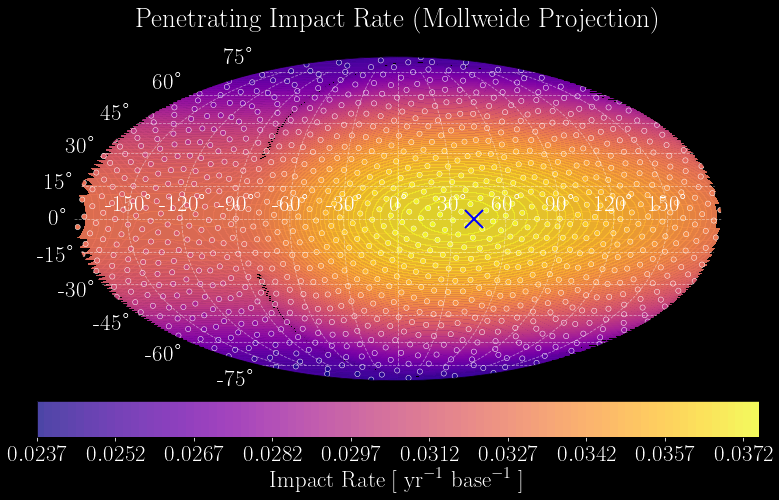

In [13]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ---------- Angle Wrapping Utility ----------
def wrap_to_180(theta):
    """Wrap angles to [-180°, +180°)."""
    return ((theta + 180) % 360) - 180

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])         # 0–180°, 0 = north
impact_rate = np.array(df["flux"])     # impacts/year

# ---------- Apply Wrapping to Longitudes ----------
theta_wrapped = wrap_to_180(-theta_list)
phi_wrapped = phi_list
impact_rate_wrapped = impact_rate

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 180),
                                   np.linspace(0, 180, 90))
theta_grid_wrapped = wrap_to_180(theta_grid)
theta_flat = theta_grid_wrapped.flatten()
phi_flat = phi_grid.flatten()
interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# ---------- Convert to Mollweide Coordinates ----------
theta_moll = np.radians(theta_wrapped)
phi_moll = np.radians((phi_wrapped - 90) * -1.0)
theta_grid_moll = np.radians(theta_grid_wrapped)
phi_grid_moll = np.radians((phi_grid - 90) * -1.0)

# ---------- Plot ----------
fig = plt.figure(figsize=(13, 7), facecolor='black')
ax = fig.add_subplot(111, projection="mollweide", facecolor='black')

# Plot Earth location
ax.plot(np.radians(42.45), 0,
        'x', ms=18,
        mfc='blue', mec='blue', mew=2,
        zorder=1000, label="Earth")

# Contour plot
cf = ax.contourf(theta_grid_moll, phi_grid_moll, impact_rate_grid, levels=100,
                 cmap="plasma", alpha=0.75)

# Scatter plot
sc = ax.scatter(theta_moll, phi_moll, c=impact_rate, cmap="plasma",
                s=27, edgecolors="white", linewidth=0.5)

# Colorbar
cbar = plt.colorbar(cf, ax=ax, orientation="horizontal", pad=0.05, shrink=0.79)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

# Tick font colors
ax.tick_params(axis='both', which='major', labelsize=23, colors='white')

# Grid and layout and title
plt.grid(True, linestyle="--", color="white", alpha=0.5)
plt.title("Penetrating Impact Rate (Mollweide Projection)",
          fontsize=27, pad=30, color='white')

plt.tight_layout()
plt.savefig('./figures/shielded_impact_rate_mollweide_dark.pdf', facecolor='black')
plt.show()


# Now let's try a polar projection at the North and South Pole

## let's plot the impact rate with a 10^-6 g minimum mass 

#### this represents the impact rate for all micrometeoroids, so with no consideration for reasonable shielding
#### i.e., this answers the question what is NASA does no shielding (which obviously it will not do.....)

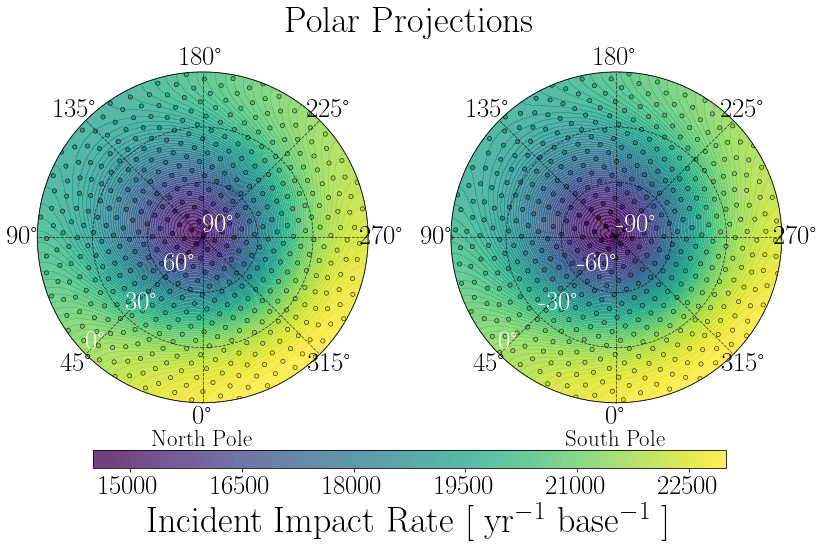

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from matplotlib.ticker import FixedLocator, FuncFormatter

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])          # 0–180°, 0 = north
impact_rate = np.array(df["flux"])      # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),
                                   np.linspace(0, 180, 180))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# Set color limits based on raw data
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Prepare for Polar Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(11, 8), subplot_kw={'projection': 'polar'})

# Define subplot centers: (theta_center, phi_center)
centers = np.array([(0, 90), (0, -90)])
titles = ["North Pole", "South Pole"]

# Flatten interpolated data
theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

# Simulated data (original)
lon_sim = np.radians(theta_list)
phi_sim = (phi_list - 90) * -1.0  # in degrees (latitude!)

for ax, (theta_c, phi_c), title in zip(axes.flat, centers, titles):
    # Interpolated data for background
    lon_rad = np.radians(theta_plot)
    phi_deg = (phi_plot - 90) * -1.0  # Latitude in degrees

    if phi_c == 90:
        args = np.where(phi_deg > 0)
        args_sim = np.where(phi_sim > 0)
        r_bg = 90 - phi_deg[args]   # Radial distance: 0° (pole) at center, 90° (equator) outer
        r_sim = 90 - phi_sim[args_sim]
    else:
        args = np.where(phi_deg <= 0)
        args_sim = np.where(phi_sim <= 0)
        r_bg = 90 + phi_deg[args]   # South pole
        r_sim = 90 + phi_sim[args_sim]

    lon_rad_sel = lon_rad[args]
    impact_sel = impact_plot[args]


    
    # plot contours of interpolation
    # Select only Northern or Southern hemisphere points
    if phi_c == 90:
        mask = phi_deg > 0
        r_grid = 90 - phi_deg[mask]   # Radial distance (north pole)
    else:
        mask = phi_deg <= 0
        r_grid = 90 + phi_deg[mask]   # Radial distance (south pole)

    theta_grid_selected = lon_rad[mask]
    impact_selected = impact_plot[mask]

    # Reshape to 2D grid
    n_theta = len(np.unique(theta_grid))
    n_phi = len(np.unique(phi_grid))

    theta_full_grid = lon_rad.reshape(n_phi, n_theta)
    phi_full_grid = phi_plot.reshape(n_phi, n_theta)

    if phi_c == 90:
        r_full_grid = 90 - (phi_full_grid - 90) * -1.0  # North
    else:
        r_full_grid = 90 + (phi_full_grid - 90) * -1.0# South

    # Now, plot contourf
    cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                     cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.75)


    # Plot simulated points
    lon_sim_sel = lon_sim[args_sim]
    impact_sim_sel = impact_rate[args_sim]

    ax.scatter(lon_sim_sel, r_sim, c=impact_sim_sel, cmap='viridis',
               s=18, edgecolors="black", linewidth=0.5,
               vmin=vmin, vmax=vmax)

    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=23, y=-.147)

    # Set radial labels to show latitude
    ax.set_rlim(0, 90)
    if phi_c == 90: #North
        ax.set_rgrids([0, 30, 60, 90], labels=["90°", "60°", "30°", "0°"], 
                     angle=45, fontsize=27, color='w')
        ax.set_rlabel_position(45)  # move labels away from 0°
    else: #South
        ax.set_rgrids([0, 30, 60, 90], labels=["-90°", "-60°", "-30°", "0°"], 
                      angle=45, fontsize=27, color='w')
        ax.set_rlabel_position(45)  # move labels away from 0°
        
    ax.grid(True, linestyle="--", color="black", alpha=0.7)
    
    #change theta label fontsize
    ax.tick_params(axis='x', labelsize=27)


fig.subplots_adjust(
    left=0.03,    # default is ~0.125
    right=.97,   # default is ~0.9
    bottom=0.2,
    top=0.8,
    wspace=0.25
)

# Colorbar
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.03])

cbar = fig.colorbar(
    cf,
    cax=cbar_ax,
    orientation="horizontal"
)
cbar.locator = MaxNLocator(nbins=8, integer=True, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=27)
cbar.set_label(r"Incident Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)

# ---------- Colorbar Ticks and Formatter ----------
'''
num_ticks = 5
tick_vals = np.linspace(vmin, vmax, num_ticks)

def smart_format(x, pos):
    if abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])
'''


fig.suptitle("Polar Projections", fontsize=36, y=.9)



plt.savefig('./figures/impact_rate_polar.pdf', bbox_inches='tight')

plt.show()



In [37]:
print('min: ', np.min(impact_rate))
print('max: ', np.max(impact_rate))
print('ratio: ', np.max(impact_rate)/np.min(impact_rate))

min:  14780.37561074529
max:  22983.06693543496
ratio:  1.5549717774916583


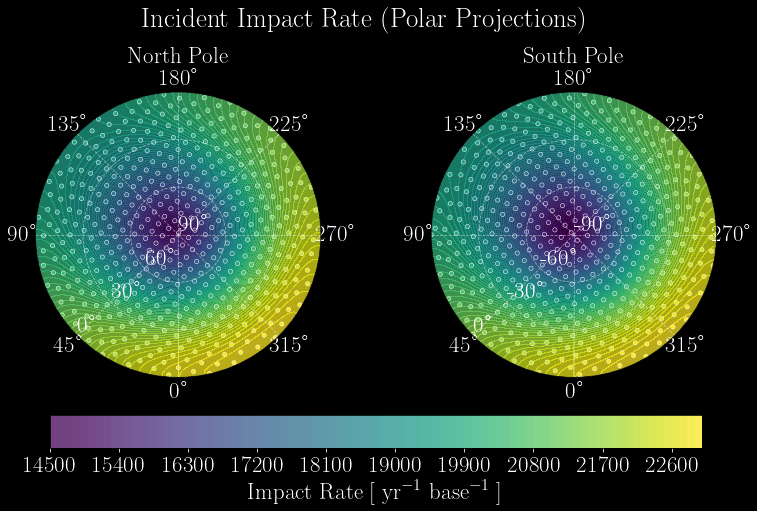

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from matplotlib.ticker import FixedLocator, FuncFormatter

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])
phi_list = np.array(df["phi"])
impact_rate = np.array(df["flux"])

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),
                                   np.linspace(0, 180, 180))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Prepare for Polar Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(13, 7), subplot_kw={'projection': 'polar'}, facecolor='black')

centers = np.array([(0, 90), (0, -90)])
titles = ["North Pole", "South Pole"]

theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

lon_sim = np.radians(theta_list)
phi_sim = (phi_list - 90) * -1.0

for ax, (theta_c, phi_c), title in zip(axes.flat, centers, titles):
    ax.set_facecolor('black')

    lon_rad = np.radians(theta_plot)
    phi_deg = (phi_plot - 90) * -1.0

    if phi_c == 90:
        args = np.where(phi_deg > 0)
        args_sim = np.where(phi_sim > 0)
        r_bg = 90 - phi_deg[args]
        r_sim = 90 - phi_sim[args_sim]
    else:
        args = np.where(phi_deg <= 0)
        args_sim = np.where(phi_sim <= 0)
        r_bg = 90 + phi_deg[args]
        r_sim = 90 + phi_sim[args_sim]

    lon_rad_sel = lon_rad[args]
    impact_sel = impact_plot[args]

    mask = phi_deg > 0 if phi_c == 90 else phi_deg <= 0
    r_grid = 90 - phi_deg[mask] if phi_c == 90 else 90 + phi_deg[mask]

    theta_grid_selected = lon_rad[mask]
    impact_selected = impact_plot[mask]

    n_theta = len(np.unique(theta_grid))
    n_phi = len(np.unique(phi_grid))

    theta_full_grid = lon_rad.reshape(n_phi, n_theta)
    phi_full_grid = phi_plot.reshape(n_phi, n_theta)

    r_full_grid = 90 - (phi_full_grid - 90) * -1.0 if phi_c == 90 else 90 + (phi_full_grid - 90) * -1.0

    cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                     cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.75)

    lon_sim_sel = lon_sim[args_sim]
    impact_sim_sel = impact_rate[args_sim]

    ax.scatter(lon_sim_sel, r_sim, c=impact_sim_sel, cmap='viridis',
               s=18, edgecolors="white", linewidth=0.5,
               vmin=vmin, vmax=vmax)

    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=23, color='white')

    ax.set_rlim(0, 90)
    labels = ["90°", "60°", "30°", "0°"] if phi_c == 90 else ["-90°", "-60°", "-30°", "0°"]
    ax.set_rgrids([0, 30, 60, 90], labels=labels, angle=45, fontsize=23, color='white')
    ax.set_rlabel_position(45)
    ax.tick_params(axis='x', labelsize=23, colors='white')
    ax.grid(True, linestyle="--", color="white", alpha=0.5)

# Colorbar
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.1, shrink=.9)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

fig.suptitle("Incident Impact Rate (Polar Projections)",
             fontsize=27, color='white', y=1.05)

plt.savefig('./figures/impact_rate_polar_dark.pdf', facecolor='black')
plt.show()


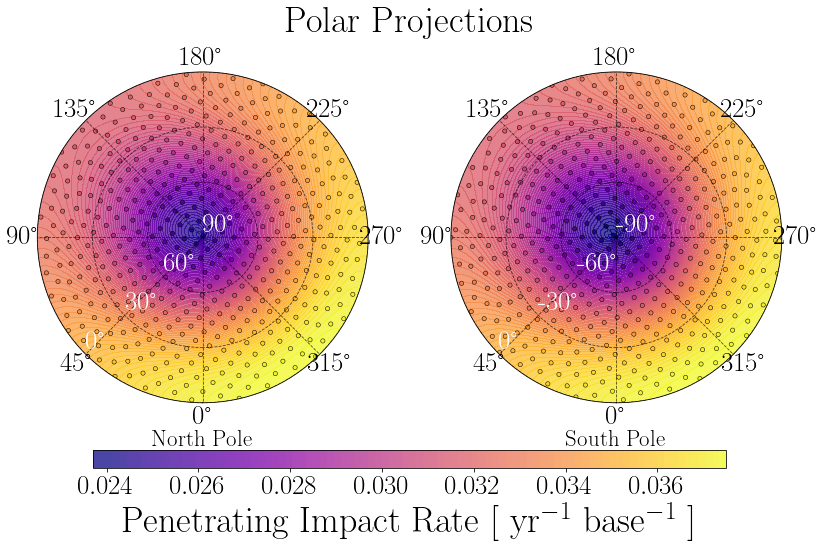

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from matplotlib.ticker import FixedLocator, FuncFormatter

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])          # 0–180°, 0 = north
impact_rate = np.array(df["flux"])      # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),
                                   np.linspace(0, 180, 180))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# Set color limits based on raw data
vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Prepare for Polar Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(11, 8), subplot_kw={'projection': 'polar'})

# Define subplot centers: (theta_center, phi_center)
centers = np.array([(0, 90), (0, -90)])
titles = ["North Pole", "South Pole"]

# Flatten interpolated data
theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

# Simulated data (original)
lon_sim = np.radians(theta_list)
phi_sim = (phi_list - 90) * -1.0  # in degrees (latitude!)

for ax, (theta_c, phi_c), title in zip(axes.flat, centers, titles):
    # Interpolated data for background
    lon_rad = np.radians(theta_plot)
    phi_deg = (phi_plot - 90) * -1.0  # Latitude in degrees

    if phi_c == 90:
        args = np.where(phi_deg > 0)
        args_sim = np.where(phi_sim > 0)
        r_bg = 90 - phi_deg[args]   # Radial distance: 0° (pole) at center, 90° (equator) outer
        r_sim = 90 - phi_sim[args_sim]
    else:
        args = np.where(phi_deg <= 0)
        args_sim = np.where(phi_sim <= 0)
        r_bg = 90 + phi_deg[args]   # South pole
        r_sim = 90 + phi_sim[args_sim]

    lon_rad_sel = lon_rad[args]
    impact_sel = impact_plot[args]


    
    # plot contours of interpolation
    # Select only Northern or Southern hemisphere points
    if phi_c == 90:
        mask = phi_deg > 0
        r_grid = 90 - phi_deg[mask]   # Radial distance (north pole)
    else:
        mask = phi_deg <= 0
        r_grid = 90 + phi_deg[mask]   # Radial distance (south pole)

    theta_grid_selected = lon_rad[mask]
    impact_selected = impact_plot[mask]

    # Reshape to 2D grid
    n_theta = len(np.unique(theta_grid))
    n_phi = len(np.unique(phi_grid))

    theta_full_grid = lon_rad.reshape(n_phi, n_theta)
    phi_full_grid = phi_plot.reshape(n_phi, n_theta)

    if phi_c == 90:
        r_full_grid = 90 - (phi_full_grid - 90) * -1.0  # North
    else:
        r_full_grid = 90 + (phi_full_grid - 90) * -1.0# South

    # Now, plot contourf
    cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                     cmap="plasma", vmin=vmin, vmax=vmax, alpha=0.75)


    # Plot simulated points
    lon_sim_sel = lon_sim[args_sim]
    impact_sim_sel = impact_rate[args_sim]

    ax.scatter(lon_sim_sel, r_sim, c=impact_sim_sel, cmap='plasma',
               s=18, edgecolors="black", linewidth=0.5,
               vmin=vmin, vmax=vmax)

    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=23, y=-.147)

    # Set radial labels to show latitude
    ax.set_rlim(0, 90)
    if phi_c == 90: #North
        ax.set_rgrids([0, 30, 60, 90], labels=["90°", "60°", "30°", "0°"], 
                     angle=45, fontsize=27, color='w')
        ax.set_rlabel_position(45)  # move labels away from 0°
    else: #South
        ax.set_rgrids([0, 30, 60, 90], labels=["-90°", "-60°", "-30°", "0°"], 
                      angle=45, fontsize=27, color='w')
        ax.set_rlabel_position(45)  # move labels away from 0°
        
    ax.grid(True, linestyle="--", color="black", alpha=0.7)
    
    #change theta label fontsize
    ax.tick_params(axis='x', labelsize=27)


fig.subplots_adjust(
    left=0.03,    # default is ~0.125
    right=.97,   # default is ~0.9
    bottom=0.2,
    top=0.8,
    wspace=0.25
)

# Colorbar
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.03])

cbar = fig.colorbar(
    cf,
    cax=cbar_ax,
    orientation="horizontal"
)
cbar.locator = MaxNLocator(nbins=8, integer=True, prune=None)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=27)
cbar.set_label(r"Penetrating Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36)


# ---------- Colorbar Ticks and Formatter ----------
'''
num_ticks = 5
tick_vals = np.linspace(vmin, vmax, num_ticks)

def smart_format(x, pos):
    if abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])
'''


fig.suptitle("Polar Projections", fontsize=36, y=.9)


plt.savefig('./figures/shielded_impact_rate_polar.pdf', bbox_inches='tight')

plt.show()


In [35]:
print('min: ', np.min(impact_rate))
print('max: ', np.max(impact_rate))
print('ratio: ', np.max(impact_rate)/np.min(impact_rate))

min:  0.0241004650628423
max:  0.0374755425555872
ratio:  1.5549717591701737


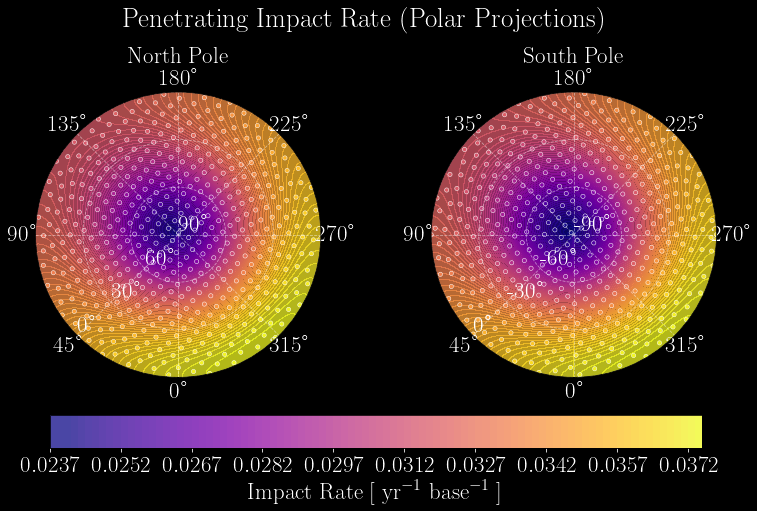

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])
phi_list = np.array(df["phi"])
impact_rate = np.array(df["flux"])

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),
                                   np.linspace(0, 180, 180))
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

vmin = np.min(impact_rate)
vmax = np.max(impact_rate)

# ---------- Prepare for Polar Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(13, 7), subplot_kw={'projection': 'polar'}, facecolor='black')

centers = np.array([(0, 90), (0, -90)])
titles = ["North Pole", "South Pole"]

theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

lon_sim = np.radians(theta_list)
phi_sim = (phi_list - 90) * -1.0

for ax, (theta_c, phi_c), title in zip(axes.flat, centers, titles):
    ax.set_facecolor('black')

    lon_rad = np.radians(theta_plot)
    phi_deg = (phi_plot - 90) * -1.0

    if phi_c == 90:
        args = np.where(phi_deg > 0)
        args_sim = np.where(phi_sim > 0)
        r_bg = 90 - phi_deg[args]
        r_sim = 90 - phi_sim[args_sim]
    else:
        args = np.where(phi_deg <= 0)
        args_sim = np.where(phi_sim <= 0)
        r_bg = 90 + phi_deg[args]
        r_sim = 90 + phi_sim[args_sim]

    lon_rad_sel = lon_rad[args]
    impact_sel = impact_plot[args]

    mask = phi_deg > 0 if phi_c == 90 else phi_deg <= 0
    r_grid = 90 - phi_deg[mask] if phi_c == 90 else 90 + phi_deg[mask]

    theta_grid_selected = lon_rad[mask]
    impact_selected = impact_plot[mask]

    n_theta = len(np.unique(theta_grid))
    n_phi = len(np.unique(phi_grid))

    theta_full_grid = lon_rad.reshape(n_phi, n_theta)
    phi_full_grid = phi_plot.reshape(n_phi, n_theta)

    r_full_grid = 90 - (phi_full_grid - 90) * -1.0 if phi_c == 90 else 90 + (phi_full_grid - 90) * -1.0

    cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                     cmap="plasma", vmin=vmin, vmax=vmax, alpha=0.75)

    lon_sim_sel = lon_sim[args_sim]
    impact_sim_sel = impact_rate[args_sim]

    ax.scatter(lon_sim_sel, r_sim, c=impact_sim_sel, cmap='plasma',
               s=18, edgecolors="white", linewidth=0.5,
               vmin=vmin, vmax=vmax)

    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=23, color='white')

    ax.set_rlim(0, 90)
    if phi_c == 90:
        ax.set_rgrids([0, 30, 60, 90], labels=["90°", "60°", "30°", "0°"],
                      angle=45, fontsize=23, color='white')
    else:
        ax.set_rgrids([0, 30, 60, 90], labels=["-90°", "-60°", "-30°", "0°"],
                      angle=45, fontsize=23, color='white')

    ax.set_rlabel_position(45)
    ax.tick_params(axis='x', labelsize=23, colors='white')
    ax.grid(True, linestyle="--", color="white", alpha=0.5)

# Colorbar
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.1, shrink=.9)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23, color='white')
cbar.ax.tick_params(labelsize=23, colors='white')

fig.suptitle("Penetrating Impact Rate (Polar Projections)",
             fontsize=27, color='white', y=1.05)

plt.savefig('./figures/shielded_impact_rate_polar_dark.pdf', facecolor='black')
plt.show()


# What if we zoom in on the South Pole and look at the potential bases

## let's plot the impact rate with a 10^-6 g minimum mass

#### this represents the impact rate for all micrometeoroids, so with no consideration for reasonable shielding
#### i.e., this answers the question what is NASA does no shielding (which obviously it will not do.....)

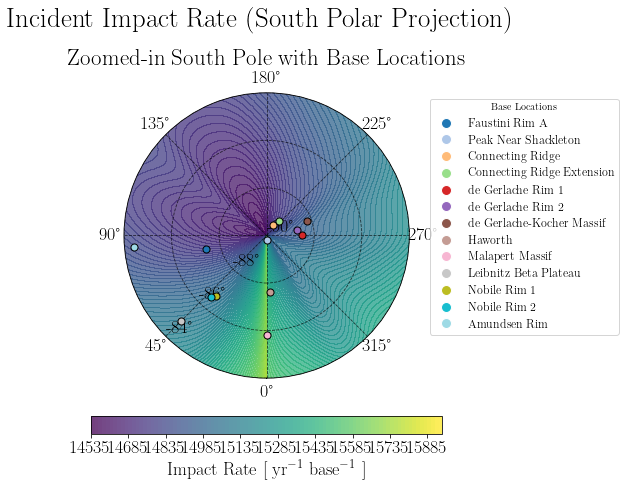

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m6.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])          # 0–180°, 0 = north
impact_rate = np.array(df["flux"])      # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid for Zoomed-In Region ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),  # Full longitudes, fine grid
                                   np.linspace(170, 180, 100))  # Focused on South Pole (latitudes from -90° to -80°)
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# Set color limits based on raw data
vmin = np.min(interp_flat)
vmax = np.max(interp_flat)

# ---------- Prepare for South Pole Polar Plot ----------
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})

# Flatten interpolated data
theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

# Select South Pole (phi <= 0 after flipping latitude)
lon_rad = np.radians(theta_plot)
phi_deg = (phi_plot - 90) * -1.0  # Latitude in degrees

# Select southern hemisphere (phi_deg <= 0)
mask = phi_deg <= 0
theta_selected = lon_rad[mask]
r_selected = 90 + phi_deg[mask]   # Radial distance: 0 at pole, 90 at equator
impact_selected = impact_plot[mask]

# Reshape for contour plotting
n_theta = len(np.unique(theta_grid))
n_phi = len(np.unique(phi_grid))
theta_full_grid = lon_rad.reshape(n_phi, n_theta)
phi_full_grid = phi_plot.reshape(n_phi, n_theta)
r_full_grid = 90 + (phi_full_grid - 90) * -1.0  # South Pole radial coordinates

# Plot interpolation only
cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                 cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.75)

# Plot lunar base locations
theta_base = np.array([77.0, 0.0, 210.0, 220.0, 270.0, 260.0, 250.0, 356.6, 0.0, 45.0, 40.0, 42.0, 85.0])
phi_base = np.array([-87.4, -89.8, -89.5, -89.2, -88.5, -88.7, -88.2, -87.6, -85.8, -84.9, -86.7, -86.5, -84.4]) * -1 + 90
name_base = ["Faustini Rim A", "Peak Near Shackleton", "Connecting Ridge", "Connecting Ridge Extension", 
             "de Gerlache Rim 1", "de Gerlache Rim 2", "de Gerlache-Kocher Massif", "Haworth", 
             "Malapert Massif", "Leibnitz Beta Plateau", "Nobile Rim 1", "Nobile Rim 2", "Amundsen Rim"]

# Convert latitude and longitude to polar coordinates for plotting
theta_base_rad = np.radians(theta_base)
phi_base_deg = (phi_base - 90) * -1.0  # Latitude in degrees

# Mask the points for the South Pole region (phi <= 0)
mask_base = phi_base_deg <= 0

# Assign unique colors to each base
base_colors = plt.cm.get_cmap('tab20', len(name_base))  # Use a colormap with distinct colors
color_list = base_colors(np.linspace(0, 1, len(name_base)))

# Plot the base locations with their corresponding colors
handles = []
for i, name in enumerate(np.array(name_base)[mask_base]):
    label = name
    color = color_list[i]
    
    # Plot base location
    ax.scatter(np.radians(theta_base[i]), 90 + (phi_base[i] - 90) * -1.0, c=[color], s=50, 
               edgecolors="black", zorder=5)

    
    # Create a handle for the legend
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label))

# Polar formatting
ax.set_theta_zero_location("S")
ax.set_theta_direction(-1)
ax.set_title("Zoomed-in South Pole with Base Locations", fontsize=23)

ax.set_rlim(0, 6)
ax.set_rgrids([0, 2, 4, 6], labels=["-90°", "-88°", "-86°", "-84°"], 
              angle=45, fontsize=18)
ax.set_rlabel_position(45)
ax.tick_params(axis='x', labelsize=18)
ax.grid(True, linestyle="--", color="black", alpha=0.7)

# Colorbar
cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.1, shrink=0.9)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=18)

'''
# Format colorbar ticks
num_ticks = 5
tick_vals = np.linspace(vmin, vmax, num_ticks)

def smart_format(x, pos):
    if abs(x) < 1e-3:
        return f"{x:.4f}"
    elif abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])
'''
cbar.ax.tick_params(labelsize=18)

# Title
fig.suptitle("Incident Impact Rate (South Polar Projection)", fontsize=27, y=1.05)

# Add a legend
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), title="Base Locations", fontsize=12)


plt.savefig('./figures/impact_rate_bases.pdf')


plt.show()


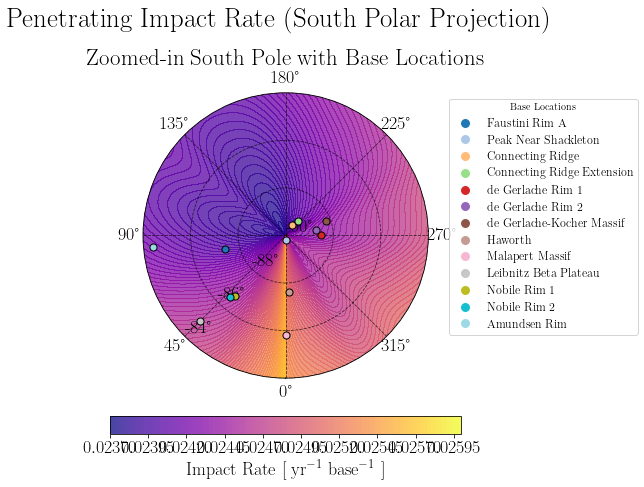

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ---------- Constants ----------
r_moon = 1737.4  # Moon radius in km

# ---------- Load Data ----------
#df = pd.read_csv("./data/flux_rates_high_fidelity_full.csv")
df = pd.read_csv("./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv")
theta_list = np.array(df["theta"])     # 0–360°
phi_list = np.array(df["phi"])          # 0–180°, 0 = north
impact_rate = np.array(df["flux"])      # impacts/year

# ---------- Longitude Wrapping ----------
wrap_threshold = 10
wrap_left = theta_list < wrap_threshold
wrap_right = theta_list > (360 - wrap_threshold)

theta_wrapped = np.concatenate([
    theta_list,
    theta_list[wrap_left] + 360,
    theta_list[wrap_right] - 360
])
phi_wrapped = np.concatenate([
    phi_list,
    phi_list[wrap_left],
    phi_list[wrap_right]
])
impact_rate_wrapped = np.concatenate([
    impact_rate,
    impact_rate[wrap_left],
    impact_rate[wrap_right]
])

# ---------- Interpolation Function ----------
def interp_impact_rates(phi_vals, theta_vals, impact_vals, phi_eval, theta_eval):
    rbf = Rbf(theta_vals, phi_vals, impact_vals, function="multiquadric", smooth=1)
    return rbf(theta_eval, phi_eval)

# ---------- Interpolation Grid for Zoomed-In Region ----------
theta_grid, phi_grid = np.meshgrid(np.linspace(0, 360, 360),  # Full longitudes, fine grid
                                   np.linspace(170, 180, 100))  # Focused on South Pole (latitudes from -90° to -80°)
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()

interp_flat = interp_impact_rates(phi_wrapped, theta_wrapped, impact_rate_wrapped,
                                  phi_flat, theta_flat)
impact_rate_grid = interp_flat.reshape(phi_grid.shape)

# Set color limits based on raw data
vmin = np.min(interp_flat)
vmax = np.max(interp_flat)

# ---------- Prepare for South Pole Polar Plot ----------
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})

# Flatten interpolated data
theta_plot = theta_grid.flatten()
phi_plot = phi_grid.flatten()
impact_plot = impact_rate_grid.flatten()

# Select South Pole (phi <= 0 after flipping latitude)
lon_rad = np.radians(theta_plot)
phi_deg = (phi_plot - 90) * -1.0  # Latitude in degrees

# Select southern hemisphere (phi_deg <= 0)
mask = phi_deg <= 0
theta_selected = lon_rad[mask]
r_selected = 90 + phi_deg[mask]   # Radial distance: 0 at pole, 90 at equator
impact_selected = impact_plot[mask]

# Reshape for contour plotting
n_theta = len(np.unique(theta_grid))
n_phi = len(np.unique(phi_grid))
theta_full_grid = lon_rad.reshape(n_phi, n_theta)
phi_full_grid = phi_plot.reshape(n_phi, n_theta)
r_full_grid = 90 + (phi_full_grid - 90) * -1.0  # South Pole radial coordinates

# Plot interpolation only
cf = ax.contourf(theta_full_grid, r_full_grid, impact_rate_grid, levels=100,
                 cmap="plasma", vmin=vmin, vmax=vmax, alpha=0.75)

# Plot lunar base locations
theta_base = np.array([77.0, 0.0, 210.0, 220.0, 270.0, 260.0, 250.0, 356.6, 0.0, 45.0, 40.0, 42.0, 85.0])
phi_base = np.array([-87.4, -89.8, -89.5, -89.2, -88.5, -88.7, -88.2, -87.6, -85.8, -84.9, -86.7, -86.5, -84.4]) * -1 + 90
name_base = ["Faustini Rim A", "Peak Near Shackleton", "Connecting Ridge", "Connecting Ridge Extension", 
             "de Gerlache Rim 1", "de Gerlache Rim 2", "de Gerlache-Kocher Massif", "Haworth", 
             "Malapert Massif", "Leibnitz Beta Plateau", "Nobile Rim 1", "Nobile Rim 2", "Amundsen Rim"]

# Convert latitude and longitude to polar coordinates for plotting
theta_base_rad = np.radians(theta_base)
phi_base_deg = (phi_base - 90) * -1.0  # Latitude in degrees

# Mask the points for the South Pole region (phi <= 0)
mask_base = phi_base_deg <= 0

# Assign unique colors to each base
base_colors = plt.cm.get_cmap('tab20', len(name_base))  # Use a colormap with distinct colors
color_list = base_colors(np.linspace(0, 1, len(name_base)))

# Plot the base locations with their corresponding colors
handles = []
for i, name in enumerate(np.array(name_base)[mask_base]):
    label = name
    color = color_list[i]
    
    # Plot base location
    ax.scatter(np.radians(theta_base[i]), 90 + (phi_base[i] - 90) * -1.0, c=[color], s=50, 
               edgecolors="black", zorder=5)

    
    # Create a handle for the legend
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label))

# Polar formatting
ax.set_theta_zero_location("S")
ax.set_theta_direction(-1)
ax.set_title("Zoomed-in South Pole with Base Locations", fontsize=23)

ax.set_rlim(0, 6)
ax.set_rgrids([0, 2, 4, 6], labels=["-90°", "-88°", "-86°", "-84°"], 
              angle=45, fontsize=18)
ax.set_rlabel_position(45)
ax.tick_params(axis='x', labelsize=18)
ax.grid(True, linestyle="--", color="black", alpha=0.7)

# Colorbar
cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.1, shrink=0.9)
cbar.set_label(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=18)

'''
# Format colorbar ticks
num_ticks = 5
tick_vals = np.linspace(vmin, vmax, num_ticks)

def smart_format(x, pos):
    if abs(x) < 1e-3:
        return f"{x:.4f}"
    elif abs(x) < 1e-2:
        return f"{x:.3f}"
    elif abs(x) < 1:
        return f"{x:.2f}"
    else:
        return f"{x:.1f}"

cbar.set_ticks(tick_vals)
cbar.set_ticklabels([smart_format(val, None) for val in tick_vals])
'''
cbar.ax.tick_params(labelsize=18)

# Title
fig.suptitle("Penetrating Impact Rate (South Polar Projection)", fontsize=27, y=1.05)

# Add a legend
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), title="Base Locations", fontsize=12)


plt.savefig('./figures/shielded_impact_rate_bases.pdf')


plt.show()


# We can also look at how impact rate scales with minimum mass and compare this to the theoretical Grun density relationship used in MEM3

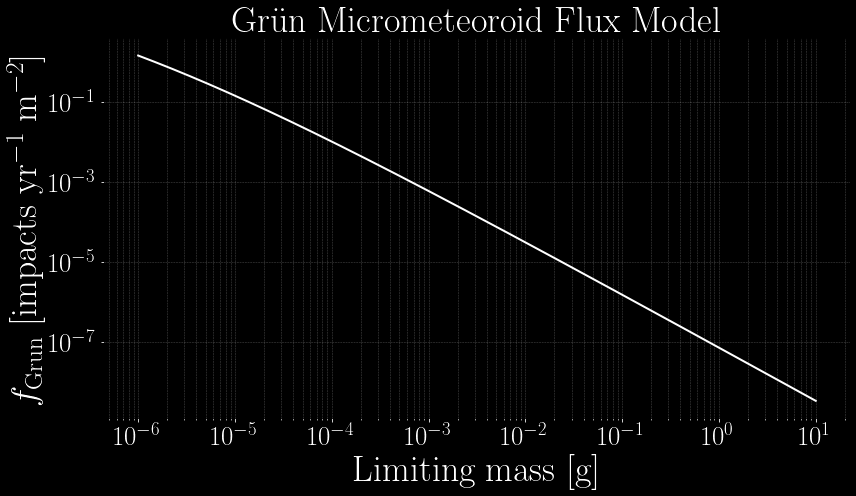

In [20]:
SEC_PER_YEAR = 3.154e+7

def grun(m):
    c4,c5,c6,c7,c8,c9,c10 = 2.2e3, 15, 1.3e-9, 1e11, 1e27, 1.3e-16, 1e6
    y4,y5,y6,y7,y8,y9,y10=0.306,-4.38,2,4,-0.36, 2,-0.85
    a = np.power((c4*np.power(m,y4) + c5),y5)
    b = c6*np.power(m+c7*np.power(m,y6) + c8*np.power(m, y7),y8)
    c = c9*np.power(m + c10*np.power(m, y9),y10)
    return (a+b+c)*SEC_PER_YEAR


# Mass range
m_vals = np.logspace(-6, 1, 500)
f_vals = grun(m_vals)

# Plot setup
plt.figure(figsize=(12, 7), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Plot
plt.plot(m_vals, f_vals, color='white', linewidth=2)

# Log scale
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel("Limiting mass [g]", fontsize=36, color='white')
plt.ylabel(r"$f_{\mathrm{Grun}}$ [impacts yr$^{-1}$ m$^{-2}$]", fontsize=36, color='white')
plt.title("Grün Micrometeoroid Flux Model", fontsize=36, color='white')

# Ticks and grid
ax.tick_params(axis='both', which='both', colors='white', labelsize=27)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='white', alpha=0.3)

# Save and show
plt.tight_layout()
plt.savefig("./figures/grun_flux_dark.png", facecolor='black', bbox_inches='tight')
plt.show()

In [21]:
def read_flux_file(name):
    df = pd.read_csv(name)
    thetas = np.array(df["theta"])
    phis = np.array(df["phi"])
    impact_rate = np.array(df["flux"])
    std = np.array(df['std'])
    return thetas, phis, impact_rate, std


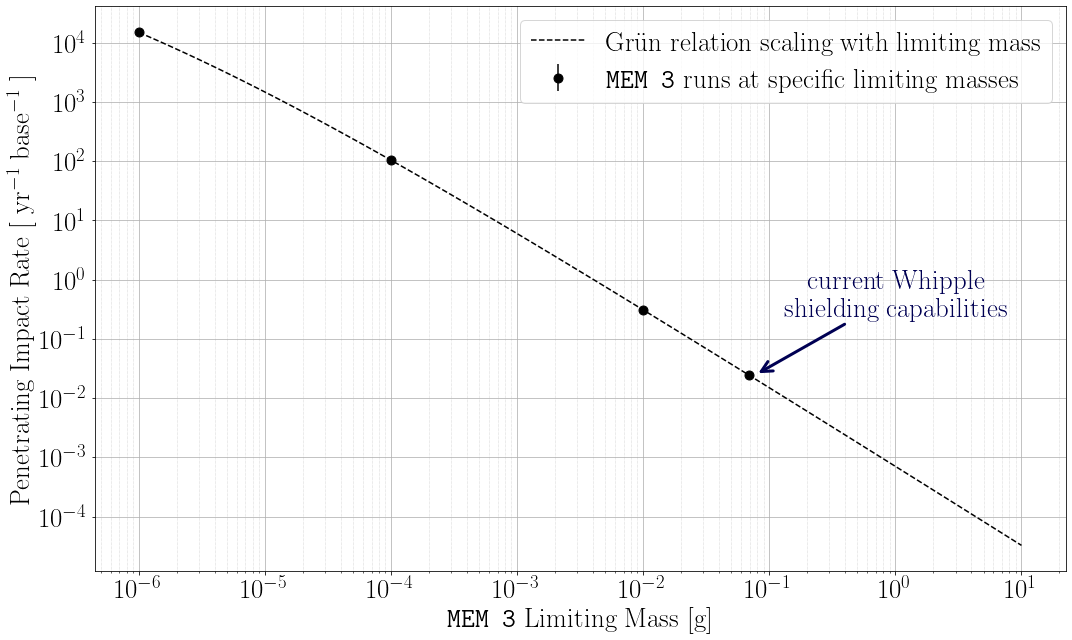

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

fnames = ["./impact_rate_results/flux_files/flux_rates_1000_m6.csv", 
          "./impact_rate_results/flux_files/flux_rates_1000_m4.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m2.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv"]
min_mass = np.power(10, np.array([-6.0, -4.0, -2.0, -1.16]))
mean_flux = []
mean_std = []
mean_southern = []
mean_southern_std = []

for fname in fnames:
    thetas, phis, flux, flux_std = read_flux_file(fname)
    mean_flux.append(np.mean(flux))
    mean_std.append(np.mean(flux_std))
    filt = np.where(phis > 174)
    mean_southern.append(np.mean(flux[filt]))
    mean_southern_std.append(np.mean(flux_std[filt]))

mean_flux = np.array(mean_flux)
mean_std = np.array(mean_std)
mean_southern = np.array(mean_southern)
mean_southern_std = np.array(mean_southern_std)

# Grün curve for reference
m_grun = np.logspace(-6, 1, 100)
grunmass = grun(m_grun)

# Compute model prediction from scaled Grün relation
grun_model_at_masses = mean_southern[0] * grun(min_mass) / grunmass[0]

# Compute residuals: data - model
residuals = mean_southern - grun_model_at_masses

# Plotting
fig, ax1 = plt.subplots(1, figsize=(15, 9))

# Top plot: main flux vs mass
ax1.errorbar(min_mass, mean_southern, yerr=mean_southern_std, label=r"\texttt{MEM~3} runs at specific limiting masses", color="k", marker='o', ms=9, ls='')
ax1.plot(m_grun, mean_southern[0]*grunmass/grunmass[0], label= "Grün relation scaling with limiting mass", color="k", ls='--')

ax1.set_xscale("log")
ax1.set_yscale("log")
# Force ticks every decade
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation())

ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.xaxis.set_major_formatter(LogFormatterSciNotation())

ax1.set_ylabel(r"Penetrating Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=27)
ax1.set_xlabel(r"\texttt{MEM~3} Limiting Mass [g]", fontsize=27)
#ax1.set_title(r'South Pole Lunar Base Impact Rate as a Function of \texttt{MEM~3} Limiting Mass', fontsize=27)
ax1.legend(fontsize=27)
ax1.grid(which='major', linestyle='-', linewidth=0.75)
ax1.grid(which='minor', linestyle=':', linewidth=0.5)




# Coordinates of the point to annotate
x_annotate = 10**(-1.16)
y_annotate = mean_southern[-1]  # corresponding y-value (last in the list)

ax1.annotate(
    "current Whipple\nshielding capabilities",          
    xy=(x_annotate+1e-2, y_annotate+1e-3),                 
    xytext=(10e-1, y_annotate * 10),               
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color='#000053', lw=3),
    fontsize=27,
    fontweight='bold',  # native matplotlib bold
    color='#000053',
    ha='center'
)




plt.tight_layout()
plt.savefig("./figures/grun.pdf", bbox_inches="tight")
plt.show()




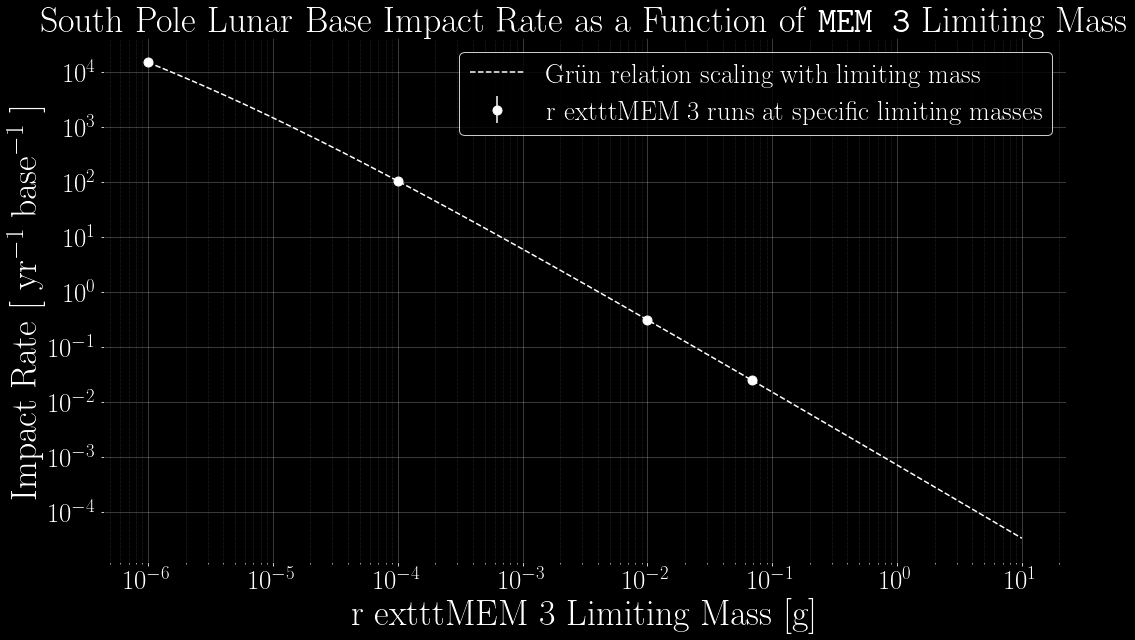

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation


fnames = ["./impact_rate_results/flux_files/flux_rates_1000_m6.csv", 
          "./impact_rate_results/flux_files/flux_rates_1000_m4.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m2.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv"]
min_mass = np.power(10, np.array([-6.0, -4.0, -2.0, -1.16]))
mean_flux = []
mean_std = []
mean_southern = []
mean_southern_std = []

for fname in fnames:
    thetas, phis, flux, flux_std = read_flux_file(fname)
    mean_flux.append(np.mean(flux))
    mean_std.append(np.mean(flux_std))
    filt = np.where(phis > 174)
    mean_southern.append(np.mean(flux[filt]))
    mean_southern_std.append(np.mean(flux_std[filt]))

mean_flux = np.array(mean_flux)
mean_std = np.array(mean_std)
mean_southern = np.array(mean_southern)
mean_southern_std = np.array(mean_southern_std)

m_grun = np.logspace(-6, 1, 100)
grunmass = grun(m_grun)
grun_model_at_masses = mean_southern[0] * grun(min_mass) / grunmass[0]
residuals = mean_southern - grun_model_at_masses

# ---------- Plot ----------
fig, ax1 = plt.subplots(1, figsize=(15, 9), facecolor='black')
ax1.set_facecolor('black')

# Plot data
ax1.errorbar(min_mass, mean_southern, yerr=mean_southern_std,
             label="r\texttt{MEM~3} runs at specific limiting masses",
             color="white", marker='o', ms=9, ls='')

# Grün curve
ax1.plot(m_grun, mean_southern[0]*grunmass/grunmass[0],
         label="Grün relation scaling with limiting mass",
         color="white", ls='--')

ax1.set_xscale("log")
ax1.set_yscale("log")

# Format ticks
ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.xaxis.set_major_formatter(LogFormatterSciNotation())
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation())

# Labels and Title
ax1.set_xlabel("r\texttt{MEM~3} Limiting Mass [g]", fontsize=36, color='white')
ax1.set_ylabel(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36, color='white')
ax1.set_title(r"South Pole Lunar Base Impact Rate as a Function of \texttt{MEM~3} Limiting Mass",
              fontsize=36, color='white')
ax1.tick_params(axis='both', which='both', labelsize=27, colors='white')

# Grid
ax1.grid(which='major', linestyle='-', linewidth=0.75, color='white', alpha=0.3)
ax1.grid(which='minor', linestyle=':', linewidth=0.5, color='white', alpha=0.3)

# Legend
ax1.legend(fontsize=27, facecolor='black', edgecolor='white', labelcolor='white')


plt.tight_layout()
plt.savefig("./figures/grun_dark_noLabel.pdf", bbox_inches="tight", facecolor='black')
plt.show()


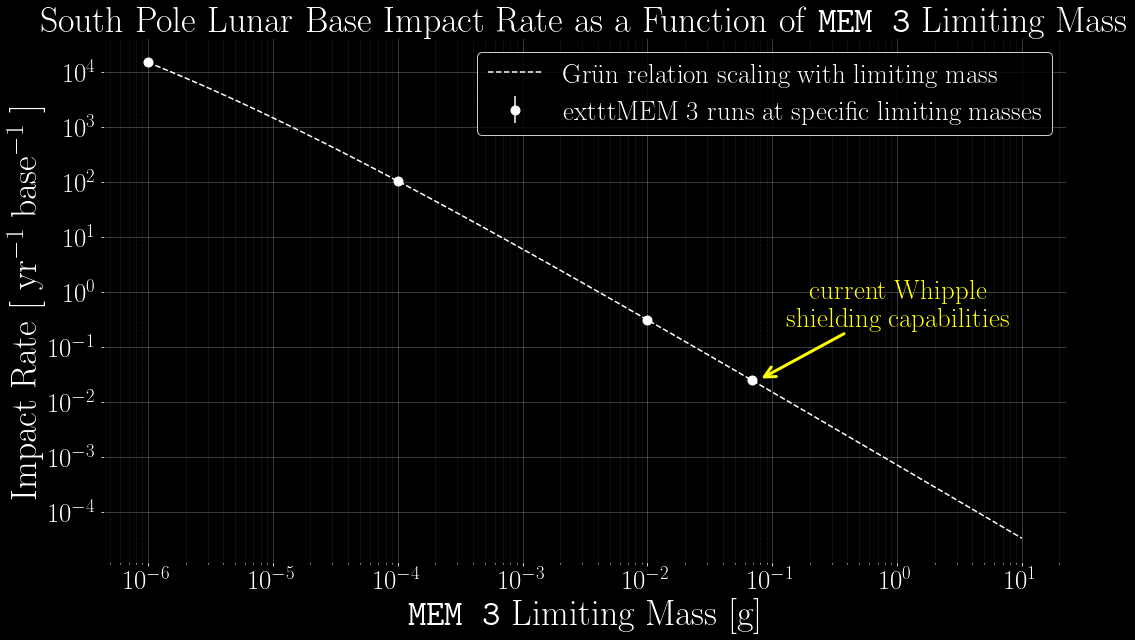

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation


fnames = ["./impact_rate_results/flux_files/flux_rates_1000_m6.csv", 
          "./impact_rate_results/flux_files/flux_rates_1000_m4.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m2.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv"]
min_mass = np.power(10, np.array([-6.0, -4.0, -2.0, -1.16]))
mean_flux = []
mean_std = []
mean_southern = []
mean_southern_std = []

for fname in fnames:
    thetas, phis, flux, flux_std = read_flux_file(fname)
    mean_flux.append(np.mean(flux))
    mean_std.append(np.mean(flux_std))
    filt = np.where(phis > 174)
    mean_southern.append(np.mean(flux[filt]))
    mean_southern_std.append(np.mean(flux_std[filt]))

mean_flux = np.array(mean_flux)
mean_std = np.array(mean_std)
mean_southern = np.array(mean_southern)
mean_southern_std = np.array(mean_southern_std)

m_grun = np.logspace(-6, 1, 100)
grunmass = grun(m_grun)
grun_model_at_masses = mean_southern[0] * grun(min_mass) / grunmass[0]
residuals = mean_southern - grun_model_at_masses

# ---------- Plot ----------
fig, ax1 = plt.subplots(1, figsize=(15, 9), facecolor='black')
ax1.set_facecolor('black')

# Plot data
ax1.errorbar(min_mass, mean_southern, yerr=mean_southern_std,
             label="\texttt{MEM~3} runs at specific limiting masses",
             color="white", marker='o', ms=9, ls='')

# Grün curve
ax1.plot(m_grun, mean_southern[0]*grunmass/grunmass[0],
         label="Grün relation scaling with limiting mass",
         color="white", ls='--')

ax1.set_xscale("log")
ax1.set_yscale("log")

# Format ticks
ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.xaxis.set_major_formatter(LogFormatterSciNotation())
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation())

# Labels and Title
ax1.set_xlabel(r"\texttt{MEM~3} Limiting Mass [g]", fontsize=36, color='white')
ax1.set_ylabel(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=36, color='white')
ax1.set_title(r"South Pole Lunar Base Impact Rate as a Function of \texttt{MEM~3} Limiting Mass",
              fontsize=36, color='white')
ax1.tick_params(axis='both', which='both', labelsize=27, colors='white')

# Grid
ax1.grid(which='major', linestyle='-', linewidth=0.75, color='white', alpha=0.3)
ax1.grid(which='minor', linestyle=':', linewidth=0.5, color='white', alpha=0.3)

# Legend
ax1.legend(fontsize=27, facecolor='black', edgecolor='white', labelcolor='white')

# Annotation
x_annotate = 10**(-1.16)
y_annotate = mean_southern[-1]

ax1.annotate(
    "current Whipple\nshielding capabilities",
    xy=(x_annotate + 1e-2, y_annotate + 1e-3),
    xytext=(10e-1, y_annotate * 10),
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color='yellow', lw=3),
    fontsize=27,
    fontweight='bold',
    color='yellow',
    ha='center'
)

plt.tight_layout()
plt.savefig("./figures/grun_dark.pdf", bbox_inches="tight", facecolor='black')
plt.show()


[2.03058949e+02 1.41232063e+00 4.19380455e-03 3.31102216e-04]


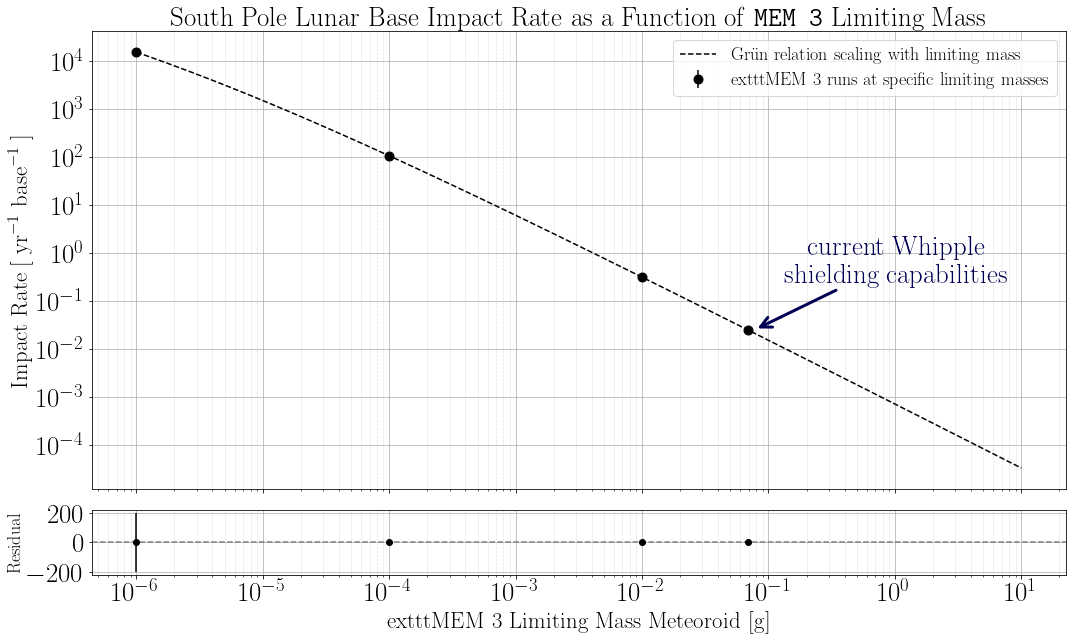

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

fnames = ["./impact_rate_results/flux_files/flux_rates_1000_m6.csv", 
          "./impact_rate_results/flux_files/flux_rates_1000_m4.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m2.csv",
          "./impact_rate_results/flux_files/flux_rates_1000_m1.16.csv"]
min_mass = np.power(10, np.array([-6.0, -4.0, -2.0, -1.16]))
mean_flux = []
mean_std = []
mean_southern = []
mean_southern_std = []

for fname in fnames:
    thetas, phis, flux, flux_std = read_flux_file(fname)
    mean_flux.append(np.mean(flux))
    mean_std.append(np.mean(flux_std))
    filt = np.where(phis > 174)
    mean_southern.append(np.mean(flux[filt]))
    mean_southern_std.append(np.mean(flux_std[filt]))

mean_flux = np.array(mean_flux)
mean_std = np.array(mean_std)
mean_southern = np.array(mean_southern)
mean_southern_std = np.array(mean_southern_std)
print(mean_southern_std)

# Grün curve for reference
m_grun = np.logspace(-6, 1, 100)
grunmass = grun(m_grun)

# Compute model prediction from scaled Grün relation
grun_model_at_masses = mean_southern[0] * grun(min_mass) / grunmass[0]

# Compute residuals: data - model
residuals = mean_southern - grun_model_at_masses

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9), sharex=True, gridspec_kw={'height_ratios': [7, 1]})

# Top plot: main flux vs mass
ax1.errorbar(min_mass, mean_southern, yerr=mean_southern_std, label="\texttt{MEM~3} runs at specific limiting masses", color="k", marker='o', ms=9, ls='')
ax1.plot(m_grun, mean_southern[0]*grunmass/grunmass[0], label= "Grün relation scaling with limiting mass", color="k", ls='--')

ax1.set_xscale("log")
ax1.set_yscale("log")
# Force ticks every decade
ax1.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.yaxis.set_major_formatter(LogFormatterSciNotation())

ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=100))
ax1.xaxis.set_major_formatter(LogFormatterSciNotation())

ax1.set_ylabel(r"Impact Rate [ yr$^{-1}$ base$^{-1}$ ]", fontsize=23)
ax1.set_title(r'South Pole Lunar Base Impact Rate as a Function of \texttt{MEM~3} Limiting Mass', fontsize=27)
ax1.legend(fontsize=18)
ax1.grid(which='major', linestyle='-', linewidth=0.75)
ax1.grid(which='minor', linestyle=':', linewidth=0.5)


ax1.annotate(
    "current Whipple\nshielding capabilities",          
    xy=(x_annotate+1e-2, y_annotate+1e-3),                 
    xytext=(10e-1, y_annotate * 10),               
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color='#000053', lw=3),
    fontsize=27,
    fontweight='bold',  # native matplotlib bold
    color='#000053',
    ha='center'
)

# Bottom plot: residuals
ax2.errorbar(min_mass, residuals, yerr=mean_southern_std, fmt='o', color='black')
ax2.axhline(0, color='gray', linestyle='--')
ax2.set_xscale("log")
ax2.set_xlabel("\texttt{MEM~3} Limiting Mass Meteoroid [g]", fontsize=23)
ax2.set_ylabel("Residual", fontsize=18)
ax2.grid(which='major', linestyle='-', linewidth=0.75)
ax2.grid(which='minor', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.savefig("./figures/grun_with_residuals.pdf", bbox_inches="tight")
plt.show()


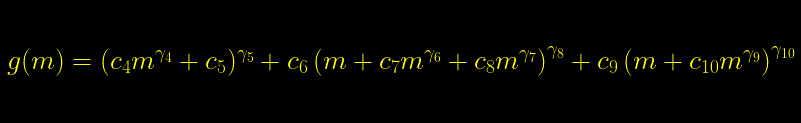

In [26]:
import matplotlib.pyplot as plt

# Enable LaTeX-style text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "text.color": "yellow"
})

# Equation string
equation = r"$g(m) = (c_4 m^{\gamma_4} + c_5)^{\gamma_5} + c_6 \left(m + c_7 m^{\gamma_6} + c_8 m^{\gamma_7} \right)^{\gamma_8} + c_9 \left(m + c_{10} m^{\gamma_9} \right)^{\gamma_{10}}$"

# Create figure
fig, ax = plt.subplots(figsize=(10, 2))
ax.text(0.5, 0.5, equation, fontsize=28, ha='center', va='center')
ax.axis('off')

# Save with black background
plt.savefig("./figures/grun_eqn.png", bbox_inches='tight', facecolor='black')
plt.show()

In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault

# Reset only the color-related rcParams to their defaults
for key in ["figure.facecolor", "axes.facecolor", "text.color"]:
    plt.rcParams[key] = rcParamsDefault[key]

## plot velocity distribution

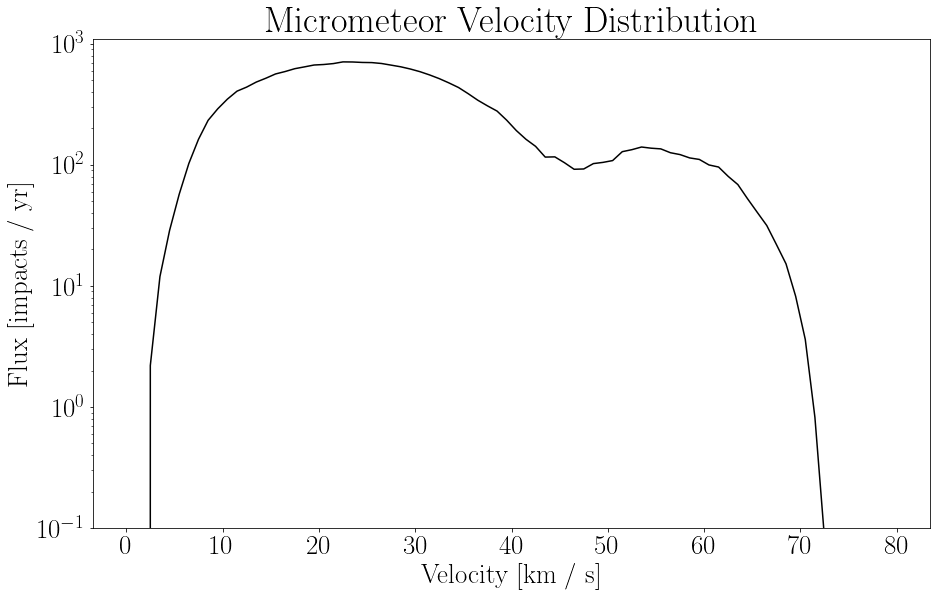

In [28]:
v = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5]
flux = [0.0, 0.0, 2.1996426539, 11.94986691, 28.7330434, 57.2104145, 102.684482, 162.505055, 233.245235, 290.333839, 348.985484, 406.233429, 438.859199, 482.98867400000006, 519.790404, 563.5535480000001, 590.231094, 622.964599, 644.700945, 667.993839, 674.5609880000001, 686.422204, 708.971493, 707.692969, 701.5490899999999, 699.508669, 687.7413379999999, 666.6007139999999, 645.7649850000001, 619.032512, 588.444534, 553.056841, 515.585599, 475.4715790000001, 435.435379, 387.412265, 341.995927, 307.32466, 278.16885169999995, 233.9203265, 192.0670782, 162.7206526, 142.19636630000002, 115.9438213, 116.41013487, 104.16488757000002, 91.962317861, 92.492345928, 102.4382862467, 104.82945577951, 108.490165282119, 128.513757, 133.514241, 140.426171, 137.305615, 135.53282199999998, 125.96715799999998, 121.588101, 114.10748900000002, 110.880671, 99.84913799999998, 95.948482, 80.304649, 68.757516, 52.586884999999995, 40.687692999999996, 31.5722507, 22.006984199999998, 15.226163199999998, 8.2184101, 3.6144047400000003, 0.82204492, 0.08165658299999999, 0.00158465146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    
phi = 89.019

fig, ax1 = plt.subplots(1, figsize=(15, 9))


plt.plot(v,flux,label=r"$\phi = $"+str(phi), color ='k')

plt.ylim(1e-1,1.1e3)
plt.yscale("log")
plt.title("Micrometeor Velocity Distribution", fontsize=36)
plt.xlabel("Velocity [km / s]", fontsize=27)
plt.ylabel("Flux [impacts / yr]", fontsize=27)
#plt.legend()
plt.savefig("figures/vel_dist.pdf", bbox_inches="tight")








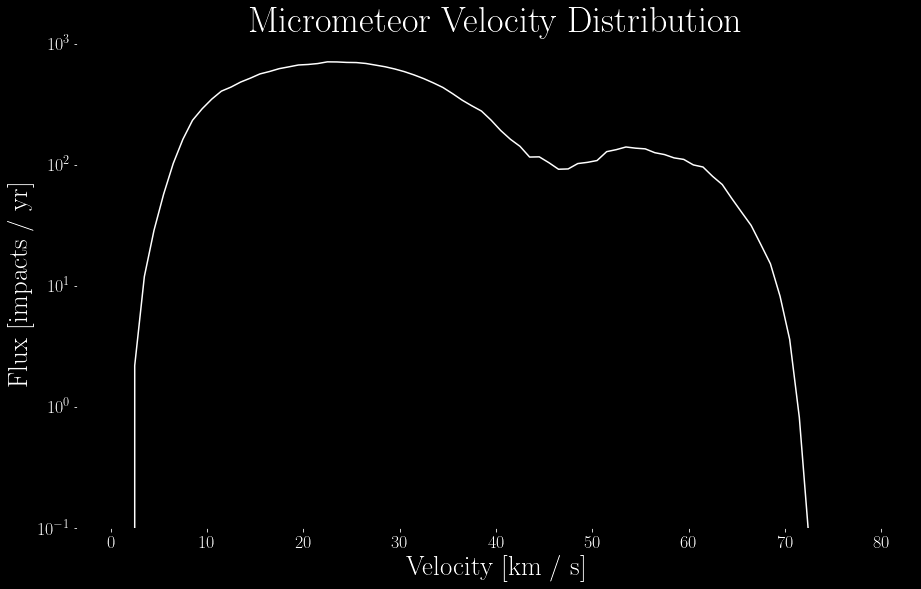

In [29]:
import matplotlib.pyplot as plt

v = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5, 77.5, 78.5, 79.5]
flux = [0.0, 0.0, 2.1996426539, 11.94986691, 28.7330434, 57.2104145, 102.684482, 162.505055, 233.245235, 290.333839, 348.985484, 406.233429, 438.859199, 482.98867400000006, 519.790404, 563.5535480000001, 590.231094, 622.964599, 644.700945, 667.993839, 674.5609880000001, 686.422204, 708.971493, 707.692969, 701.5490899999999, 699.508669, 687.7413379999999, 666.6007139999999, 645.7649850000001, 619.032512, 588.444534, 553.056841, 515.585599, 475.4715790000001, 435.435379, 387.412265, 341.995927, 307.32466, 278.16885169999995, 233.9203265, 192.0670782, 162.7206526, 142.19636630000002, 115.9438213, 116.41013487, 104.16488757000002, 91.962317861, 92.492345928, 102.4382862467, 104.82945577951, 108.490165282119, 128.513757, 133.514241, 140.426171, 137.305615, 135.53282199999998, 125.96715799999998, 121.588101, 114.10748900000002, 110.880671, 99.84913799999998, 95.948482, 80.304649, 68.757516, 52.586884999999995, 40.687692999999996, 31.5722507, 22.006984199999998, 15.226163199999998, 8.2184101, 3.6144047400000003, 0.82204492, 0.08165658299999999, 0.00158465146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
phi = 89.019

fig, ax1 = plt.subplots(1, figsize=(15, 9), facecolor='black')
ax1.set_facecolor('black')

ax1.plot(v, flux, label=r"$\phi = $" + str(phi), color='white')

ax1.set_yscale("log")
ax1.set_ylim(1e-1, 1.1e3)

ax1.set_title("Micrometeor Velocity Distribution", fontsize=36, color='white')
ax1.set_xlabel("Velocity [km / s]", fontsize=27, color='white')
ax1.set_ylabel("Flux [impacts / yr]", fontsize=27, color='white')

ax1.tick_params(axis='x', colors='white', labelsize=18)
ax1.tick_params(axis='y', colors='white', labelsize=18)

# Uncomment if you want to show the legend
# ax1.legend(facecolor='black', edgecolor='white', fontsize=20)

plt.savefig("figures/vel_dist_dark.pdf", bbox_inches="tight", facecolor='black')
plt.show()
